In [735]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [736]:
import healpy as hp
import numpy as np
import pylab as pl
import camb 
import glob
rot = hp.Rotator(coord=['C','G'])
from astropy.coordinates import SkyCoord
from astropy.io import fits
import pymaster as nmt
import sys
from scipy import stats
import copy
import pickle as pkl
sys.path.append('../code')#/Users/gfabbian/Software/PolSpice_v03-07-05/bin')
from lensing_qso_cross_utils import *

rot = hp.Rotator(coord=['C','G'])

# Intro 
The notebook aims at investigating effects of the catalog cuts as well as the selection function as well as properties of the random realizations of the catalog. 

# Data

We follow the usual approach and load the Planck PR4 map

In [737]:
nside=256
lmax=3*nside-1
beam = hp.pixwin(nside,lmax=3*nside-1,pol=False)



In [4]:
# compute delta  and k
try:
    klr=hp.read_map('../../kappa_lr.fits')
except:
    klm = hp.read_alm('../../dat_klm.fits')
    klm = hp.read_alm('/Users/gfabbian/Work/PR4_variations/PR42018like_klm_dat_MV.fits') # read DR4 instead of DR3
    fl=np.ones(4097)
    fl[3*nside-1:]=0.
    khr=hp.alm2map(hp.almxfl(klm,fl),nside=2048,pol=False)
    klr = hp.ud_grade(khr,nside_out=nside)

## Masks

We use the Planck galactic masks that leave an available sky fraction of 20-90\%. We also test the impact of the lensing mask that removes the galaxy as well as point sources.

In [5]:
galmask80_lr= hp.read_map('../../planck_galmask80.fits')
galmask90_lr= hp.read_map('../../planck_galmask90.fits')
galmask70_lr= hp.read_map('../../planck_galmask70.fits')
galmask60_lr  = hp.read_map('../../planck_galmask60.fits')
galmask50_lr= hp.read_map('../../planck_galmask50.fits')
galmask40_lr= hp.read_map('../../planck_galmask40.fits')
galmask20_lr= hp.read_map('../../planck_galmask20.fits')
lensmask_lr = hp.read_map('../../planck_lensmask.fits')

We also construct a mask removing the small and large Magellanic clouds which are regions where the selection function is very low and we do not observe objects

In [738]:
# Magellanic Cloud mask
mclouds = [(280.4652,-32.8884),(302.8084,-44.3277)] #Large MC and Small MC coordinates
r_mclouds = [4,2] #deg
#r_mclouds = [5,2] #deg
mclouds_mask = np.ones(hp.nside2npix(nside))
for i,lmc in enumerate(mclouds):
    mcpix = hp.query_disc(nside,hp.ang2vec(lmc[0],lmc[1],lonlat=True),np.deg2rad(r_mclouds[i]))
    mclouds_mask[mcpix]=0.

## Catalog

We load the selection function and apply a galactic mask keeping 80\% of the sky as baseline footprint. We also build the counts map and overdensity maps $g=\delta n/n$ for the full sample and also for 2 subsets of the sample made with just half the galaxies selected at random. I will call in the following those samples $g_{1},g_{2}$ and I also compute the jackknife of those map to have an estimate of the noise so that 
$$ g_1 = g + n_1$$
$$ g_2 = g + n_2$$
$$ g_{JK} = \frac{g_2- g_1}{2}$$

and $n$ is the noise of the map. If the sample is selected at random $<n_1n_2>=0$ in the absence of systematics and assuming the splits are made of half the data 
$$ C_\ell^{g_{JK}g_{JK}} = N_\ell^{gg}$$

where $N_\ell^{gg}$ is the noise of the catalog.

I do the same operation for the random catalog, the G20.0 and G20.4 catalogs. For each of those I also compute the map where I correct the counts dividing out the selection function prior to computing the overdensity so that the observational effects are removed.



In [739]:
# selection function and binary mask
mask_c = hp.ud_grade(hp.read_map('../../map_probability_dust_stars_m10_NSIDE64_G20.0.fits'),nside_out=nside)
mask = rot.rotate_map_pixel(mask_c)
binmask = mask>0
binmask = (mask>0)*galmask80_lr

In [7]:
# Prepare raw GAIA data
print("Read catalog and convert coordinate")
d=fits.open('../../gaia_G20.0.fits')
nqso = len(d[1].data['redshift_spz'])
print ("N_QSO in catalog",nqso)

sc = SkyCoord(ra=d[1].data["ra"], dec=d[1].data["dec"], unit='deg', frame='icrs', equinox='J2000.0')
gs = sc.transform_to(frame='galactic')
l = gs.l.value #d[1].data['l'])
b = gs.b.value # d[1].data['b'])


# Prepare raw GAIA data
print("Read catalog and convert coordinate")
d204=fits.open('../../gaia_G20.4.fits')
nqso204 = len(d204[1].data['redshift_spz'])
print ("N_QSO in catalog 20.4",nqso204)

sc204 = SkyCoord(ra=d204[1].data["ra"], dec=d204[1].data["dec"], unit='deg', frame='icrs', equinox='J2000.0')
gs204 = sc204.transform_to(frame='galactic')
l204 = gs204.l.value #d[1].data['l'])
b204 = gs204.b.value # d[1].data['b'])

Read catalog and convert coordinate
N_QSO in catalog 648842
Read catalog and convert coordinate
N_QSO in catalog 20.4 1001557


In [8]:

split_reshuffle = np.arange(nqso)
np.random.shuffle(split_reshuffle)
m=make_counts(nside,l,b)
m1=make_counts(nside,(l[split_reshuffle])[0::2],(b[split_reshuffle])[0::2])
m2=make_counts(nside,(l[split_reshuffle])[1::2],(b[split_reshuffle])[1::2])

# the survey above is for ~50% of the sky. 
# compute correction of counts by probability density. 
msel=np.zeros(hp.nside2npix(nside))
msel[binmask!=0] = m[binmask!=0]/mask[binmask!=0]

m1sel=np.zeros(hp.nside2npix(nside))
m1sel[binmask!=0] = m1[binmask!=0]/mask[binmask!=0]

m2sel=np.zeros(hp.nside2npix(nside))
m2sel[binmask!=0] = m2[binmask!=0]/mask[binmask!=0]


# G20.4
split_reshuffle204 = np.arange(nqso204)
np.random.shuffle(split_reshuffle204)
m_204=make_counts(nside,l204,b204)
m1_204=make_counts(nside,(l204[split_reshuffle204])[0::2],(b204[split_reshuffle204])[0::2])
m2_204=make_counts(nside,(l204[split_reshuffle204])[1::2],(b204[split_reshuffle204])[1::2])






In [501]:
msel_204=np.zeros(hp.nside2npix(nside))
msel_204[binmask!=0] = m_204[binmask!=0]/mask[binmask!=0]

m1sel_204=np.zeros(hp.nside2npix(nside))
m1sel_204[binmask!=0] = m1_204[binmask!=0]/mask[binmask!=0]

m2sel_204=np.zeros(hp.nside2npix(nside))
m2sel_204[binmask!=0] = m2_204[binmask!=0]/mask[binmask!=0]


In [84]:
# Randomized catalog
drnd=fits.open('../../random_stardustm1064_G20.0_10x.fits')
scrnd = SkyCoord(ra=drnd[1].data["ra"], dec=drnd[1].data["dec"], unit='deg', frame='icrs', equinox='J2000.0')
gsrnd = scrnd.transform_to(frame='galactic')
nqso_rnd = len(gsrnd.l.value)
split_reshuffle_rnd = np.arange(nqso_rnd)

mrnd = make_counts(nside,gsrnd.l.value,gsrnd.b.value)
mrnd1 = make_counts(nside,(gsrnd.l.value[split_reshuffle_rnd])[0::2],(gsrnd.b.value[split_reshuffle_rnd])[0::2])
mrnd2 = make_counts(nside,(gsrnd.l.value[split_reshuffle_rnd])[1::2],(gsrnd.b.value[split_reshuffle_rnd])[1::2])


mrndsel=np.zeros(hp.nside2npix(nside))
mrndsel[binmask!=0] = mrnd[binmask!=0]/mask[binmask!=0]

mrnd1sel=np.zeros(hp.nside2npix(nside))
mrnd1sel[binmask!=0] = mrnd1[binmask!=0]/mask[binmask!=0]

mrnd2sel=np.zeros(hp.nside2npix(nside))
mrnd2sel[binmask!=0] = mrnd2[binmask!=0]/mask[binmask!=0]


# Map statistics

Here I compute some statistics of the overdensity and counts map with and without the selection function correction applied. I do this for pixel that are observed and consider different footprints essentially applying more aggressive galactic cuts. 

It is evident that the selection function correction minimizes the effect of dust extinctions i.e. the less aggressive the cut (i.e. higher included $f_{sky}$) the mean number of objects observed stays roughly constant, while it's not the case if the selection function correction is not applied.

Also, if I rescale the mean number of objects of the G20.4 catalog (that has more quasars) so that it has the same normalization as the G20.0 catalog, the trend is the same. This means that the G20.4 catalog should have similar properties of the G20.0.

I also compute the mean of the selection function over the footprint for reference. Its trend is similar.


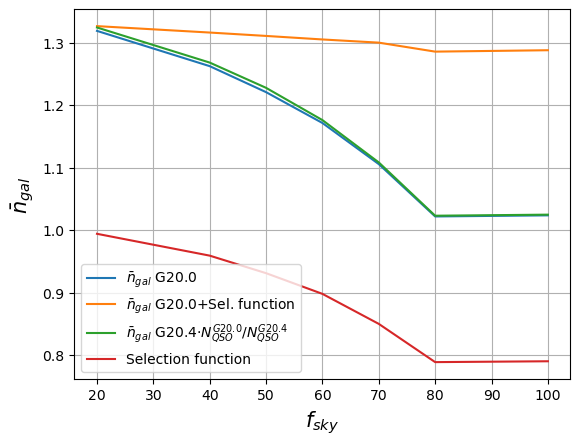

In [120]:

goodpix = binmask!=0

nbar = np.mean(m[goodpix])
nbar1 = np.mean(m1[goodpix])
nbar2 = np.mean(m2[goodpix])

nbar_fsky20 = np.mean(m[galmask20_lr!=0])
nbar_fsky40 = np.mean(m[galmask40_lr!=0])
nbar_fsky50 = np.mean(m[galmask50_lr!=0])
nbar_fsky60 = np.mean(m[galmask60_lr!=0])
nbar_fsky70 = np.mean(m[galmask70_lr!=0])
nbar_fsky80 = np.mean(m[galmask80_lr!=0])

nbar_sel        = np.mean(msel[goodpix])
nbar1_sel        = np.mean(m1sel[goodpix])
nbar2_sel        = np.mean(m2sel[goodpix])
nbar_sel_fsky20 = np.mean(msel[galmask20_lr!=0])
nbar_sel_fsky40 = np.mean(msel[galmask40_lr!=0])
nbar_sel_fsky50 = np.mean(msel[galmask50_lr!=0])
nbar_sel_fsky60 = np.mean(msel[galmask60_lr!=0])
nbar_sel_fsky70 = np.mean(msel[galmask70_lr!=0])
nbar_sel_fsky80 = np.mean(msel[galmask80_lr!=0])

nbar_204 = np.mean(m_204[goodpix])
nbar_fsky20_204 = np.mean(m_204[galmask20_lr!=0])
nbar_fsky40_204 = np.mean(m_204[galmask40_lr!=0])
nbar_fsky50_204 = np.mean(m_204[galmask50_lr!=0])
nbar_fsky60_204 = np.mean(m_204[galmask60_lr!=0])
nbar_fsky70_204 = np.mean(m_204[galmask70_lr!=0])
nbar_fsky80_204 = np.mean(m_204[galmask80_lr!=0])

selfunc_mean        = np.mean(mask[goodpix])
selfunc_mean_fsky20 = np.mean(mask[galmask20_lr!=0])
selfunc_mean_fsky40 = np.mean(mask[galmask40_lr!=0])
selfunc_mean_fsky50 = np.mean(mask[galmask50_lr!=0])
selfunc_mean_fsky60 = np.mean(mask[galmask60_lr!=0])
selfunc_mean_fsky70 = np.mean(mask[galmask70_lr!=0])
selfunc_mean_fsky80 = np.mean(mask[galmask80_lr!=0])

#### Plots
fskys = [100,80,70,60,50,40,20]
nbars = np.array([nbar,nbar_fsky80,nbar_fsky70,nbar_fsky60,nbar_fsky50,nbar_fsky40,nbar_fsky20])
nbars_sel = np.array([nbar_sel,nbar_sel_fsky80,nbar_sel_fsky70,nbar_sel_fsky60,nbar_sel_fsky50,nbar_sel_fsky40,
                      nbar_sel_fsky20])
nbars_g204 = np.array([nbar_204,nbar_fsky80_204,nbar_fsky70_204,nbar_fsky60_204,nbar_fsky50_204,nbar_fsky40_204,
                       nbar_fsky20_204])
selfuncs = [selfunc_mean,selfunc_mean_fsky80,selfunc_mean_fsky70,selfunc_mean_fsky60,selfunc_mean_fsky50,
            selfunc_mean_fsky40,selfunc_mean_fsky20]

pl.plot(fskys,nbars,label='$\\bar{n}_{gal}$ G20.0')
pl.plot(fskys,nbars_sel,label='$\\bar{n}_{gal}$ G20.0+Sel. function')
pl.plot(fskys,nbars_g204*nqso/nqso204,label='$\\bar{n}_{gal}$ G20.4$\cdot N_{QSO}^{G20.0}/N_{QSO}^{G20.4}$')
pl.plot(fskys,selfuncs,label='Selection function')
pl.xlabel("$f_{sky}$",size=15)
pl.ylabel("$\\bar{n}_{gal}$",size=15)
pl.grid()
pl.legend(loc='best')
pl.show()

In [502]:
### Compute  overdensities and jackknife splits
goodpix = binmask!=0

# the line below uses the expected mean accounting for the selection function BUT does not correct the 
# modulation induced by the selection function itself

c = overdensity_from_counts(m,goodpix,verbose=False)
c1 = overdensity_from_counts(m1,goodpix,verbose=False)
c2 = overdensity_from_counts(m2,goodpix,verbose=False)
jk =(c2-c1)/2

csel = overdensity_from_counts(msel,goodpix,verbose=False) 
c1sel = overdensity_from_counts(m1sel,goodpix,verbose=False) 
c2sel = overdensity_from_counts(m2sel,goodpix,verbose=False) 
jksel =(c2sel-c1sel)/2

c_204 = overdensity_from_counts(m_204,goodpix,verbose=False)
c1_204 = overdensity_from_counts(m1_204,goodpix,verbose=False)
c2_204 = overdensity_from_counts(m2_204,goodpix,verbose=False)
jk_204 =(c2_204-c1_204)/2

csel_204 = overdensity_from_counts(msel_204,goodpix,verbose=False)
c1sel_204 = overdensity_from_counts(m1sel_204,goodpix,verbose=False)
c2sel_204 = overdensity_from_counts(m2sel_204,goodpix,verbose=False)
jksel_204 =(c2sel_204-c1sel_204)/2

In [13]:

print("Counts Stats on sky counts !=0 ")
print("nbar          ",nbar,"mean/std counts map",np.mean(m),np.std(m))
print("nbar1         ",nbar1,"mean/std counts map",np.mean(m1),np.std(m1))
print("nbar2         ",nbar2,"mean/std counts map",np.mean(m2),np.std(m2))
print("nbar  selfunc.",nbar_sel)
print("nbar1 selfunc.",nbar1_sel,"mean/std counts map",np.mean(m1sel),np.std(m1sel))
print("nbar2 selfunc.",nbar2_sel,"mean/std counts map",np.mean(m2sel),np.std(m2sel))
print()

print("Counts Stats on sky counts !=0 & different galactic masks")
print("nbar        ",nbar)
print("nbar fsky=80",nbar_fsky80)
print("nbar fsky=70",nbar_fsky70)
print("nbar fsky=60",nbar_fsky60)
print("nbar fsky=50",nbar_fsky50)
print("nbar fsky=20",nbar_fsky20)
print()

print("nbar selfunc.        ",nbar_sel)
print("nbar selfunc. fsky=80",nbar_sel_fsky80)
print("nbar selfunc. fsky=70",nbar_sel_fsky70)
print("nbar selfunc. fsky=60",nbar_sel_fsky60)
print("nbar selfunc. fsky=50",nbar_sel_fsky50)
print("nbar selfunc. fsky=40",nbar_sel_fsky40)
print("nbar selfunc. fsky=20",nbar_sel_fsky20)
print() 

print("G20.4 Counts Stats on sky counts !=0 & different galactic masks")
print("nbar        ",nbar_204)
print("nbar fsky=80",nbar_fsky80_204)
print("nbar fsky=70",nbar_fsky70_204)
print("nbar fsky=60",nbar_fsky60_204)
print("nbar fsky=50",nbar_fsky50_204)
print("nbar fsky=40",nbar_fsky40_204)
print("nbar fsky=20",nbar_fsky20_204)
print() 

print()
print("overdensity Stats on sky counts !=0")
print("w/o selfunc. ","mean/std counts map",np.mean(c[goodpix]),np.std(c[goodpix]))
print("w/  selfunc. ","mean/std counts map",np.mean(csel[goodpix]),np.std(csel[goodpix]))
print("w/o  selfunc. G20.4 ","mean/std counts map",np.mean(c_204[goodpix]),np.std(c_204[goodpix]))
print("split 1      ","mean/std counts map",np.mean(c1[goodpix]),np.std(c1[goodpix]))
print("split 2      ","mean/std counts map",np.mean(c2[goodpix]),np.std(c2[goodpix]))
print("JK           ","mean/std counts map",np.mean(jk[goodpix]),np.std(jk[goodpix]))
print("JK W/selfunc.","mean/std counts map",np.mean(jksel[goodpix]),np.std(jksel[goodpix]))
print()




Counts Stats on sky counts !=0 
nbar           1.0237110225118995 mean/std counts map 0.8250452677408854 1.0337500142615053
nbar1          0.5119217743828348 mean/std counts map 0.4125226338704427 0.6881987698629057
nbar2          0.5117892481290646 mean/std counts map 0.4125226338704427 0.6875647262132807
nbar  selfunc. 1.2879555390176523
nbar1 selfunc. 0.6431547137011028 mean/std counts map 0.5121892405173963 0.9337352362473428
nbar2 selfunc. 0.6448008253165495 mean/std counts map 0.5135001547347094 0.9237657406814556

Counts Stats on sky counts !=0 & different galactic masks
nbar         1.0237110225118995
nbar fsky=80 1.0219340750422392
nbar fsky=70 1.1056926711708677
nbar fsky=60 1.1715087799829564
nbar fsky=50 1.2208661305813255
nbar fsky=20 1.3189227098818388

nbar selfunc.         1.2879555390176523
nbar selfunc. fsky=80 1.285719918529288
nbar selfunc. fsky=70 1.3000969497689767
nbar selfunc. fsky=60 1.3051907053237857
nbar selfunc. fsky=50 1.3108335471093753
nbar selfunc. fsky

# Plots of the maps

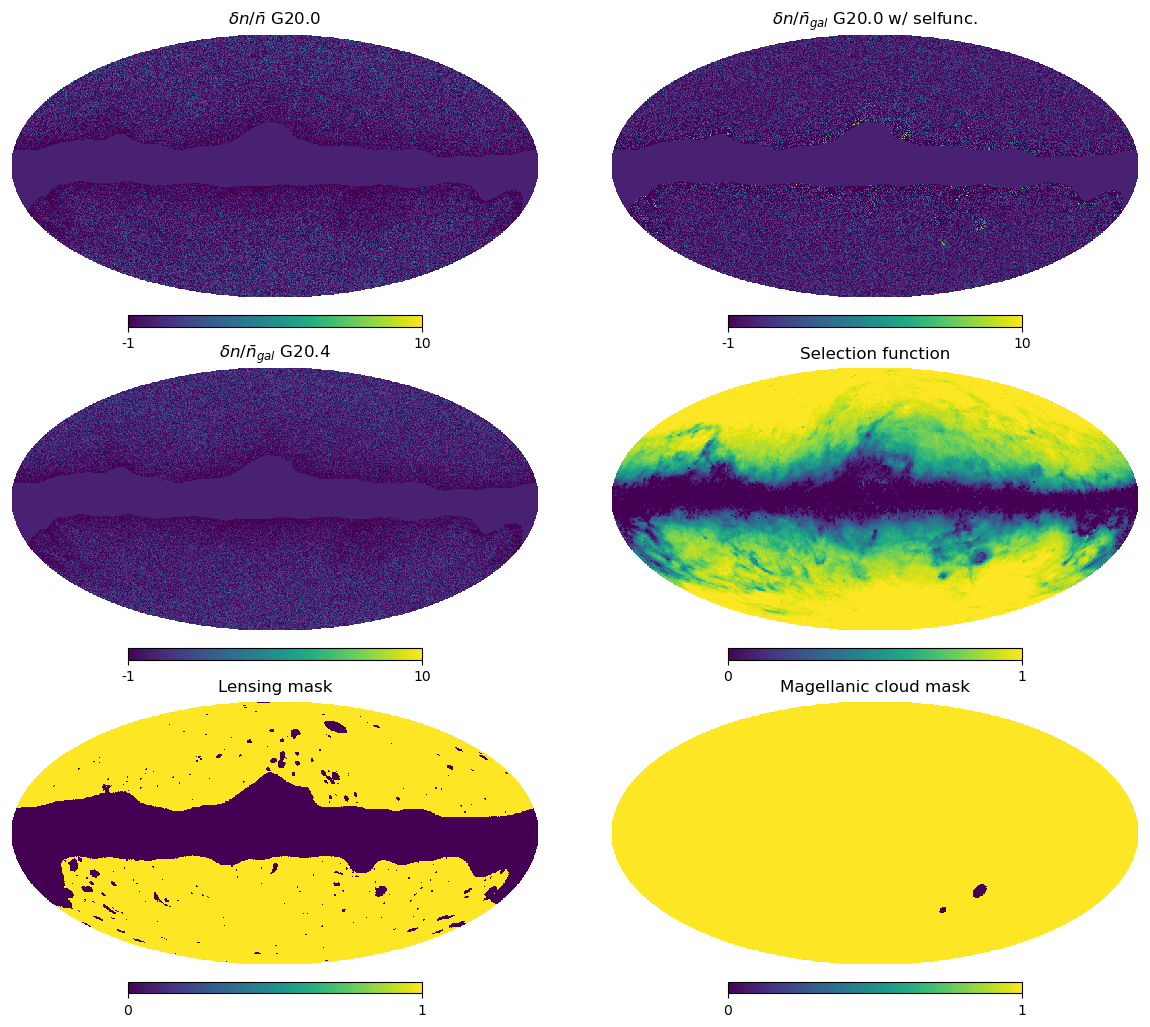

In [576]:
pl.figure(figsize=(12,10))
hp.mollview(c*galmask80_lr,max=10,sub=321,title='$\delta n/\\bar{n}$ G20.0')
hp.mollview(csel*galmask80_lr,max=10,sub=322,title='$\delta n/\\bar{n}_{gal}$ G20.0 w/ selfunc.')
hp.mollview(c_204*galmask80_lr,max=10,sub=323,title='$\delta n/\\bar{n}_{gal}$ G20.4 ')
hp.mollview(mask,sub=324,title='Selection function')
hp.mollview(lensmask_lr,sub=325,title='Lensing mask')
hp.mollview(mclouds_mask,sub=326,title='Magellanic cloud mask')
pl.show()

# Results

I compute the cross spectra between all the possible samples, subsamples and jackknife and plots results as a function of galactic mask or point source mask. I will focus on $C_\ell^{\kappa g},C_\ell^{gg},C_\ell^{gg,JK}$ and $C_\ell^{g_1g_2}$ that should give a measurement of the true $C_\ell^{gg}$ without the noise bias since the noise are mostly uncorrelated.

In [157]:
def process_mask(kappa,g,g1,g2,jk,apodized_mask,binning,w=None,return_error=False):
    # corrects for pixel window function
    beam = hp.pixwin(nside,lmax=3*nside-1,pol=False)
    
    fkappa = nmt.NmtField(apodized_mask, [klr],beam=beam) # corrects for pixel window as klr computed from downgrade
    if w is None:
        w = nmt.NmtWorkspace()
        w.compute_coupling_matrix(fkappa, fkappa, binning)    

    fg = nmt.NmtField( apodized_mask, [g],beam=beam)
    fg1 = nmt.NmtField(apodized_mask, [g1],beam=beam)
    fg2 = nmt.NmtField(apodized_mask, [g2],beam=beam)
    fjk = nmt.NmtField(apodized_mask, [jk],beam=beam)
    
    clkg = compute_master(fkappa, fg, w)[0]
    clgg = compute_master(fg, fg, w)[0]
    clkk = compute_master(fkappa, fkappa, w)[0]
    
    clkg1 = compute_master(fkappa, fg1, w)[0]
    clg1g1 = compute_master(fg1, fg1, w)[0]
    
    clkg2 = compute_master(fkappa, fg2, w)[0]
    clg2g2 = compute_master(fg2, fg2, w)[0]
    
    
    clg1g2 = compute_master(fg1, fg2, w)[0]
    clkgjk = compute_master(fkappa, fjk, w)[0]
    clgjk = compute_master(fjk, fjk, w)[0]
    
    all_data = np.array([clkg,clgg,clkk,clkg1,clg1g1,clkg2,clg2g2,clg1g2,clkgjk,clgjk])
    if return_error:
        fsky= np.mean(apomask**2)**2/np.mean(apomask**4)
        delta_ell = binning.get_nell_list()
        prefac_auto = np.sqrt(2/(2*binning.get_effective_ells() +1)/delta_ell/fsky)
        prefac_cross= prefac_auto/np.sqrt(2)
        dclkg = prefac_cross * np.sqrt(clgg*clkk+clkg**2)
        dclgg = prefac_auto * np.abs(clgg)
        dclkk = prefac_auto * np.abs(clkk)
        dclkg1 = prefac_cross * np.sqrt(clg1g1*clkk+clkg1**2)
        dclg1g1 = prefac_auto * np.abs(clg1g1)
        dclkg2 = prefac_cross * np.sqrt(clg2g2*clkk+clkg2**2)
        dclg2g2 = prefac_auto * np.abs(clg2g2)
        dclg1g2 = prefac_cross * np.sqrt(clg2g2*clg1g1+clg1g2**2)
        dclkgjk = prefac_cross * np.sqrt(clgjk*clkk+clkgjk**2)
        dclgjk = prefac_auto * np.abs(clgjk)
        error_data = np.array([dclkg,dclgg,dclkk,dclkg1,dclg1g1,dclkg2,dclg2g2,dclg1g2,dclkgjk,dclgjk])
        return all_data,error_data
    else:
        return all_data


In [503]:
def process_masklist_data(mask_list,mask_labels,dbins=[10,20]):
    cls_dict={k:{} for k in dbins}
    cls_dict['info']='clkg,clgg,clkk,clkg1,clg1g1,clkg2,clg2g2,clg1g2,clkgjk,clgjk'
    for gmask_label,gmask in zip(mask_labels,mask_list):
        apomask = nmt.mask_apodization(gmask,2., apotype="C2")
        goodpix = gmask>0
        print("Processing mask",gmask_label)
        # the line below uses the expected mean accounting for the selection function BUT does not correct the modulation itself
        #print("std")
        c = overdensity_from_counts(m,goodpix)
        c1 = overdensity_from_counts(m1,goodpix)
        c2 = overdensity_from_counts(m2,goodpix)
        jk =(c2-c1)/2
    
        #print("RND/10")
        crnd = overdensity_from_counts(mrnd,goodpix)
        crnd1 = overdensity_from_counts(mrnd1,goodpix)
        crnd2 = overdensity_from_counts(mrnd2,goodpix)    
        jkrnd = (crnd2-crnd1)/2
        
        #print("selfunc")    
        csel = overdensity_from_counts(msel,goodpix) 
        c1sel = overdensity_from_counts(m1sel,goodpix) 
        c2sel = overdensity_from_counts(m2sel,goodpix) 
        jksel =(c2sel-c1sel)/2
        
        #print("RND selfunc")    
        cselrnd = overdensity_from_counts(mrndsel,goodpix) 
        c1selrnd = overdensity_from_counts(mrnd1sel,goodpix) 
        c2selrnd = overdensity_from_counts(mrnd2sel,goodpix) 
        jkselrnd =(c2selrnd-c1selrnd)/2    
        
        #print("20.4")        
        c_204 = overdensity_from_counts(m_204,goodpix)
        c1_204 = overdensity_from_counts(m1_204,goodpix)
        c2_204 = overdensity_from_counts(m2_204,goodpix)
        jk_204 =(c2_204-c1_204)/2
    
        csel_204 = overdensity_from_counts(msel_204,goodpix)
        c1sel_204 = overdensity_from_counts(m1sel_204,goodpix)
        c2sel_204 = overdensity_from_counts(m2sel_204,goodpix)
        jksel_204 =(c2sel_204-c1sel_204)/2
        
    
        for dbin in dbins:
            cls_dict[dbin][gmask_label]={}
            binning = get_custom_binning(dbin)
            lb = binning.get_effective_ells()        
            cls_dict[dbin][gmask_label]['cls'] = process_mask(klr,c,c1,c2,jk,apomask,binning,return_error = True)
            cls_dict[dbin][gmask_label]['cls_204'] = process_mask(klr,c_204,c1_204,c2_204,jk_204,apomask,binning,
                                                                return_error = True) 
            cls_dict[dbin][gmask_label]['cls_sel'] = process_mask(klr,csel,c1sel,c2sel,jksel,apomask,binning,
                                                                return_error = True) 
            cls_dict[dbin][gmask_label]['cls_204_sel'] = process_mask(klr,csel_204,c1sel_204,c2sel_204,jksel_204,
                                                                apomask,binning,return_error = True) 
            
            cls_dict[dbin][gmask_label]['cls_wmask'] = process_mask(klr,c,c1,c2,jk,apomask*mask,binning,
                                                                  return_error = True)
            cls_dict[dbin][gmask_label]['cls_sel_wmask']= process_mask(klr,csel,c1sel,c2sel,jksel,apomask*mask,binning,
                                                                     return_error = True)
            
            cls_dict[dbin][gmask_label]['cls_204_wmask'] = process_mask(klr,c_204,c1_204,c2_204,jk_204,apomask*mask,
                                                                binning,return_error = True)
            cls_dict[dbin][gmask_label]['cls_204_sel_wmask']= process_mask(klr,csel_204,c1sel_204,c2sel_204,
                                                                jksel_204,apomask*mask,binning,return_error = True) 

            cls_dict[dbin][gmask_label]['cls_rnd']= process_mask(klr,crnd,crnd1,crnd2,jkrnd,apomask,binning,
                                            return_error = True)    
            cls_dict[dbin][gmask_label]['cls_sel_rnd'] = process_mask(klr,cselrnd,c1selrnd,c2selrnd,jkselrnd,apomask,
                                                                      binning,return_error = True) 
            cls_dict[dbin][gmask_label]['cls_rnd_wmask']= process_mask(klr,crnd,crnd1,crnd2,jkrnd,apomask*mask,
                                                                binning,return_error = True)    
            cls_dict[dbin][gmask_label]['cls_sel_rnd_wmask'] = process_mask(klr,cselrnd,c1selrnd,c2selrnd,jkselrnd,
                                                                apomask*mask,binning,return_error = True)
            cls_dict[dbin]['ls']=lb
    cls_dict['info']='binning->mask-> data,err->[clkg,clgg,clkk,clkg1,clg1g1,clkg2,clg2g2,clg1g2,clkgjk,clgjk]'    
    return cls_dict

In [161]:
def get_custom_binning(delta_b=20,delta_b_high_l=50,lmax_transition=100):
    lmin_low_ells = np.arange(0,lmax_transition,delta_b)
    lmax_low_ells = lmin_low_ells + delta_b
    lmin_low_ells[0]=2
    lmin_high_ells = np.arange(lmax_transition,lmax-delta_b_high_l,delta_b_high_l)
    lmax_high_ells = lmin_high_ells+delta_b_high_l
    lmax_high_ells[-1]=lmax
    
    lmins = np.append(lmin_low_ells,lmin_high_ells)
    lmaxs = np.append(lmax_low_ells,lmax_high_ells)
    
    binning = define_binning(lmins,lmaxs,delta_b=delta_b,nside=nside,weighting='ivar')
    return binning


In [740]:
try:
    with open("../cls_analysis_dict.pkl","rb") as f:
        cls_dict=pkl.load(f)
except:
    mask_list = [galmask80_lr,galmask70_lr,galmask60_lr,galmask50_lr,galmask40_lr,galmask20_lr]
    mask_labels = [80,70,60,50,40,20]
    dbins = [10,20]    
    cls_dict = process_masklist_data(mask_list,mask_labels,dbins=[10,20])
    with open("../cls_analysis_dict.pkl","wb") as f:
        pkl.dump(cls_dict,f)            

Processing mask 80
Processing mask 70
Processing mask 60
Processing mask 50
Processing mask 40
Processing mask 20


In [742]:
try:
    dasdsa
    with open("../cls_analysis_dict_mcmask.pkl","rb") as f:
        cls_dict_mcmask=pkl.load(f)
except:
    mask_list = [galmask80_lr*mclouds_mask,galmask70_lr*mclouds_mask,galmask60_lr*mclouds_mask,galmask50_lr*mclouds_mask,
                 galmask40_lr*mclouds_mask,galmask20_lr*mclouds_mask]
    mask_labels = [80,70,60,50,40,20]
    dbins = [10,20]    
    cls_dict_mcmask = process_masklist_data(mask_list,mask_labels,dbins=[10,20])
    with open("../cls_analysis_dict_mcmask.pkl","wb") as f:
        pkl.dump(cls_dict_mcmask,f)  

Processing mask 80
Processing mask 70
Processing mask 60
Processing mask 50
Processing mask 40
Processing mask 20


In [743]:
try:
    dsadsa
    with open("../cls_analysis_dict_lensmask.pkl","rb") as f:
        cls_dict_lensmask=pkl.load(f)
except:
    mask_list = [galmask80_lr*lensmask_lr,galmask70_lr*lensmask_lr,galmask60_lr*lensmask_lr,
                 galmask50_lr*lensmask_lr,galmask40_lr*lensmask_lr,galmask20_lr*lensmask_lr]
    mask_labels = [80,70,60,50,40,20]
    dbins = [10,20]    
    cls_dict_lensmask = process_masklist_data(mask_list,mask_labels,dbins=[10,20])
    with open("../cls_analysis_dict_lensmask.pkl","wb") as f:
        pkl.dump(cls_dict_lensmask,f) 

Processing mask 80
Processing mask 70
Processing mask 60
Processing mask 50
Processing mask 40
Processing mask 20


## Trend with $f_{sky}$

The $\kappa g$ cross-correlation is stable and weakly sensitive to the galactic sky mask for $\ell>40$. The $gg$ auto-spectrum is however changing strongly especially the large scales if no selection function correction is applied.

The selection function correction stabilizes all the trends for all observables although again the cross-correlation is more stable. The auto spectrum for aggressive cuts (i.e. the fsk=20 mask) is stable as the selection function there is basically always equal to 1.

Notice also that $C_\ell^{g_1g_2}$ displays lots of power still at large scales suggesting some potential residual systematic or a correlated noise component between the subsamples of the catalog. The jackknife in fact gets rid of this excess power and the power spectrum is essentially consistent with the shot noise 

$$C_\ell^{gg,JK} \approx \Delta\Omega_{pixel}/\bar{n}$$

where $\bar{n}$ is the mean number of objects over the footprint.

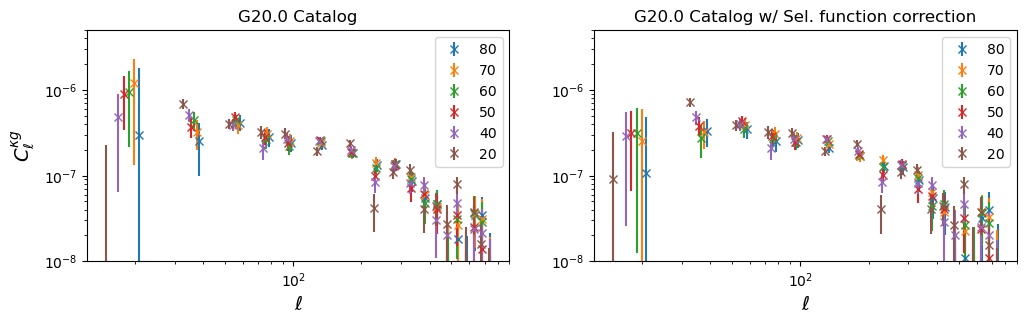

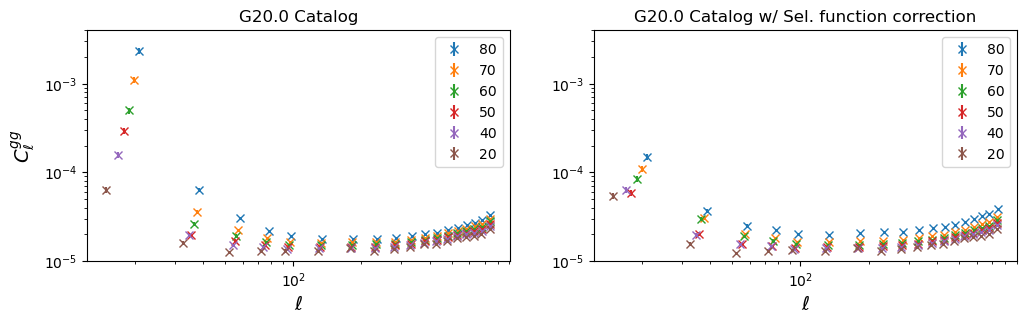

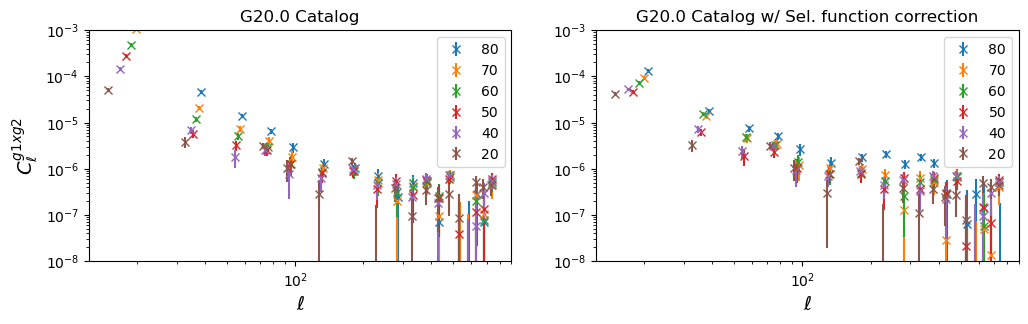

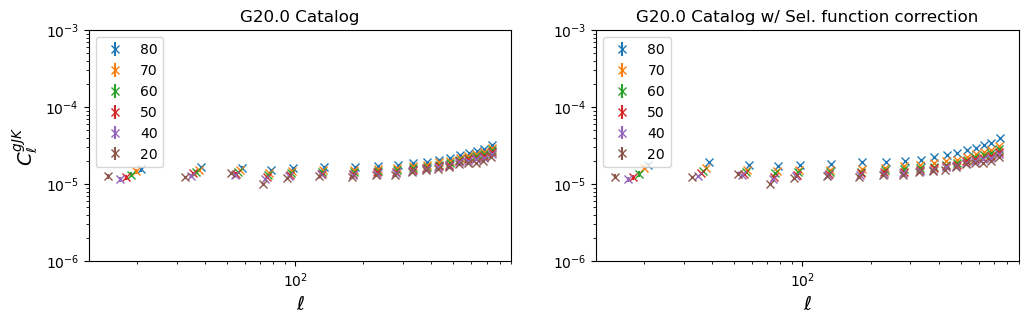

In [744]:
fsize = (12,3)

f,ax = pl.subplots(1,2,figsize=fsize )
for i in mask_labels:
    ax[0].errorbar(cls_dict[20]['ls']+0.1*i,cls_dict[20][i]['cls'][0][0],cls_dict[20][i]['cls'][1][0],marker='x',ls='',label='%d'%i)
    ax[1].errorbar(cls_dict[20]['ls']+0.1*i,cls_dict[20][i]['cls_sel'][0][0],cls_dict[20][i]['cls_sel'][1][0],marker='x',ls='',label='%d'%i)
for k in range(2):
    ax[k].legend()
    ax[k].set_yscale("log")
    ax[k].set_xscale("log")
    ax[k].set_ylim(1e-08,5e-06)
    ax[k].set_xlabel("$\ell$",size=14)    
ax[0].set_ylabel("$C_\ell^{\kappa g}$",size=14)
ax[0].set_title("G20.0 Catalog")
ax[1].set_title("G20.0 Catalog w/ Sel. function correction")
ax[0].set_title("G20.0 Catalog")
ax[1].set_title("G20.0 Catalog w/ Sel. function correction") 
pl.show()


f,ax = pl.subplots(1,2,figsize=fsize)
for i in mask_labels:
    ax[0].errorbar(cls_dict[20]['ls']+0.1*i,cls_dict[20][i]['cls'][0][1],cls_dict[20][i]['cls'][1][1],marker='x',ls='',label='%d'%i)
    ax[1].errorbar(cls_dict[20]['ls']+0.1*i,cls_dict[20][i]['cls_sel'][0][1],cls_dict[20][i]['cls_sel'][1][1],marker='x',ls='',label='%d'%i)
for k in range(2):
    ax[k].legend()
    ax[k].set_yscale("log")
    ax[k].set_xscale("log")
    ax[k].set_ylim(1e-05,4e-03)
    ax[k].set_xlabel("$\ell$",size=14)    
ax[0].set_ylabel("$C_\ell^{gg}$",size=14)  
ax[0].set_title("G20.0 Catalog")
ax[1].set_title("G20.0 Catalog w/ Sel. function correction") 
pl.show()

f,ax = pl.subplots(1,2,figsize=fsize)
for i in mask_labels:
    ax[0].errorbar(cls_dict[20]['ls']+0.1*i,cls_dict[20][i]['cls'][0][7],cls_dict[20][i]['cls'][1][7],marker='x',ls='',label='%d'%i)
    ax[1].errorbar(cls_dict[20]['ls']+0.1*i,cls_dict[20][i]['cls_sel'][0][7],cls_dict[20][i]['cls_sel'][1][7],marker='x',ls='',label='%d'%i)
for k in range(2):
    ax[k].legend()
    ax[k].set_yscale("log")
    ax[k].set_xscale("log")
    ax[k].set_ylim(1e-08,1e-03)
    ax[k].set_xlabel("$\ell$",size=14)    
ax[0].set_ylabel("$C_\ell^{g1xg2}$",size=14)    
ax[0].set_title("G20.0 Catalog")
ax[1].set_title("G20.0 Catalog w/ Sel. function correction") 
pl.show() 

f,ax = pl.subplots(1,2,figsize=fsize)
for i in mask_labels:
    ax[0].errorbar(cls_dict[20]['ls']+0.1*i,cls_dict[20][i]['cls'][0][-1],cls_dict[20][i]['cls'][1][-1],marker='x',ls='',label='%d'%i)
    ax[1].errorbar(cls_dict[20]['ls']+0.1*i,cls_dict[20][i]['cls_sel'][0][-1],cls_dict[20][i]['cls_sel'][1][-1],marker='x',ls='',label='%d'%i)
for k in range(2):
    ax[k].legend()
    ax[k].set_yscale("log")
    ax[k].set_xscale("log")
    ax[k].set_ylim(1e-06,1e-03)
    ax[k].set_xlabel("$\ell$",size=14)    
ax[0].set_ylabel("$C_\ell^{gJK}$",size=14)
ax[0].set_title("G20.0 Catalog")
ax[1].set_title("G20.0 Catalog w/ Sel. function correction")    
pl.show() 

## Random catalog null tests and properties

Here I show some results using the full random catalog 
* The cross-correlation with CMB lensing with the full sample of the random catalog is consistent with 0 as expected but if I apply the selection function correction the error bar seems much smaller for the first 2 bins. 
* The $C_\ell^{gg}$ auto-spectrum improves by a lot if the selection function is applied. For improvement I mean tha spectrum flattens and is much more stable when I apply more aggressive galactic masks. The differeences are compatible with the change in $\bar{n}$ as a function of $f_{sky}$.
* $C_\ell^{gg,JK}$ again is weakly sensitive to the selection function correction and lower than the power observed in the data as we have 10x more objects.
* $C_\ell^{g1xg2}$ is as expected consistent with 0 since no clustering is present in the random catalogs. However the selection function correction improves the first bin dramatically and gets rid of the correlations induced by the systematics that survive if the correction is not applied.

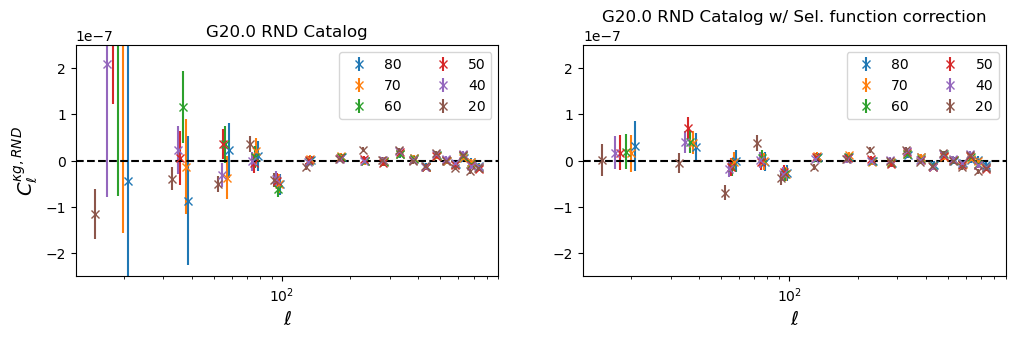

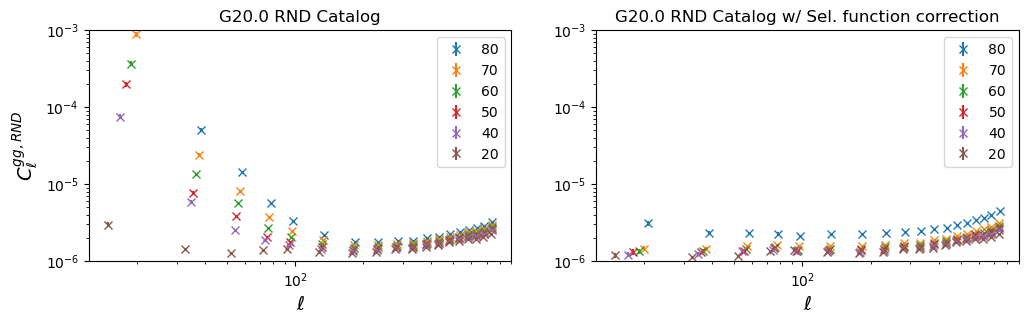

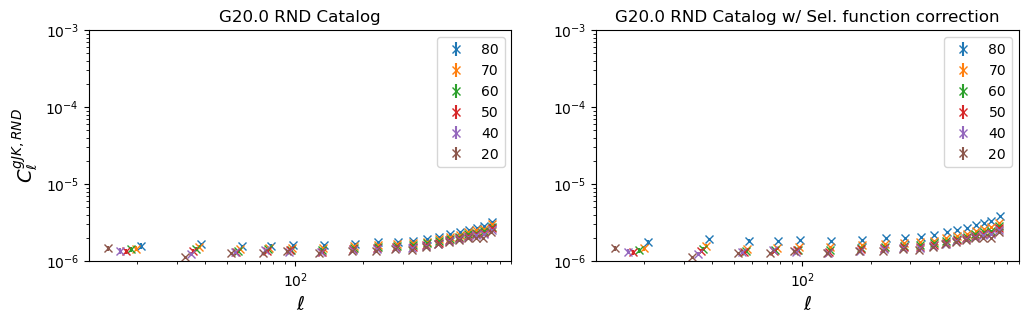

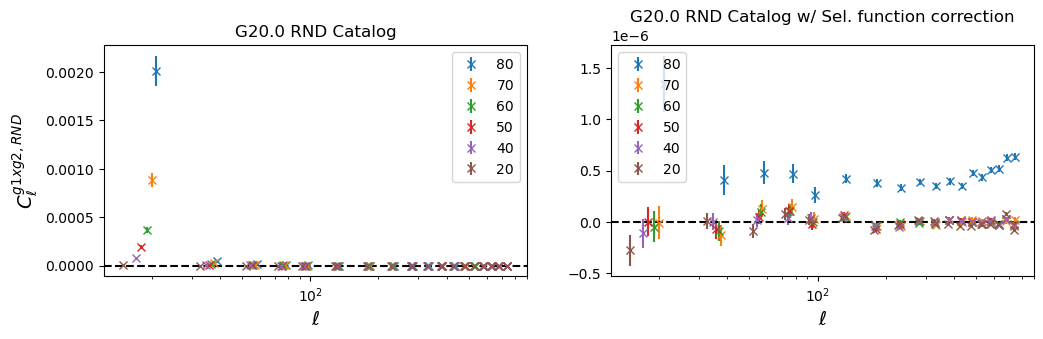

In [745]:

f,ax = pl.subplots(1,2,figsize=fsize)
for i in mask_labels:
    ax[0].errorbar(cls_dict[20]['ls']+0.1*i,cls_dict[20][i]['cls_rnd'][0][0],cls_dict[20][i]['cls_rnd'][1][0],
                   marker='x',ls='',label='%d'%i)
    ax[1].errorbar(cls_dict[20]['ls']+0.1*i,cls_dict[20][i]['cls_sel_rnd'][0][0],
                   cls_dict[20][i]['cls_sel_rnd'][1][0],marker='x',ls='',label='%d'%i)
for k in range(2):
    ax[k].legend(ncol=2)
    #ax[k].set_yscale("log")
    ax[k].set_xscale("log")
    ax[k].set_ylim(-1e-06/4,1e-06/4)
    ax[k].set_xlabel("$\ell$",size=14)  
    ax[k].axhline(0,ls='--',color='black')
ax[0].set_ylabel("$C_\ell^{\kappa g,RND}$",size=14)    
ax[0].set_title("G20.0 RND Catalog")
ax[1].set_title("G20.0 RND Catalog w/ Sel. function correction")    
pl.show() 


f,ax = pl.subplots(1,2,figsize=fsize)
for i in mask_labels:
    ax[0].errorbar(cls_dict[20]['ls']+0.1*i,cls_dict[20][i]['cls_rnd'][0][1],cls_dict[20][i]['cls_rnd'][1][1],
                   marker='x',ls='',label='%d'%i)
    ax[1].errorbar(cls_dict[20]['ls']+0.1*i,cls_dict[20][i]['cls_sel_rnd'][0][1],
                   cls_dict[20][i]['cls_sel_rnd'][1][1],marker='x',ls='',label='%d'%i)
for k in range(2):
    ax[k].legend()
    ax[k].set_yscale("log")
    ax[k].set_xscale("log")
    ax[k].set_ylim(1e-06,1e-03)
    ax[k].set_xlabel("$\ell$",size=14)    
ax[0].set_ylabel("$C_\ell^{gg,RND}$",size=14)    
ax[0].set_title("G20.0 RND Catalog")
ax[1].set_title("G20.0 RND Catalog w/ Sel. function correction")    
pl.show() 


f,ax = pl.subplots(1,2,figsize=fsize)
for i in mask_labels:
    ax[0].errorbar(cls_dict[20]['ls']+0.1*i,cls_dict[20][i]['cls_rnd'][0][-1],cls_dict[20][i]['cls_rnd'][1][-1],
                   marker='x',ls='',label='%d'%i)
    ax[1].errorbar(cls_dict[20]['ls']+0.1*i,cls_dict[20][i]['cls_sel_rnd'][0][-1],
                   cls_dict[20][i]['cls_sel_rnd'][1][-1],marker='x',ls='',label='%d'%i)
for k in range(2):
    ax[k].legend()
    ax[k].set_yscale("log")
    ax[k].set_xscale("log")
    ax[k].set_ylim(1e-06,1e-03)
    ax[k].set_xlabel("$\ell$",size=14)    
ax[0].set_ylabel("$C_\ell^{gJK,RND}$",size=14)    
ax[0].set_title("G20.0 RND Catalog")
ax[1].set_title("G20.0 RND Catalog w/ Sel. function correction")    
pl.show() 

f,ax = pl.subplots(1,2,figsize=fsize)
for i in mask_labels:
    ax[0].errorbar(cls_dict[20]['ls']+0.1*i,cls_dict[20][i]['cls_rnd'][0][7],cls_dict[20][i]['cls_rnd'][1][7],
                   marker='x',ls='',label='%d'%i)
    ax[1].errorbar(cls_dict[20]['ls']+0.1*i,cls_dict[20][i]['cls_sel_rnd'][0][7],
                   cls_dict[20][i]['cls_sel_rnd'][1][7],marker='x',ls='',label='%d'%i)
for k in range(2):
    ax[k].legend()
    #ax[k].set_yscale("log")
    ax[k].set_xscale("log")
    #ax[k].set_ylim(1e-08,1e-03)
    #ax[k].set_ylim(-0.5e-06,2e-06)
    ax[k].set_xlabel("$\ell$",size=14)    
    ax[k].axhline(0,ls='--',color='black')
ax[0].set_ylabel("$C_\ell^{g1xg2,RND}$",size=14)    
ax[0].set_title("G20.0 RND Catalog")
ax[1].set_title("G20.0 RND Catalog w/ Sel. function correction")    
pl.show() 


## Magnitude cut effects.

I compare the results on data for the G20.0 and G20.4 catalogs. I assumed the selection function is similar for both catalogs and applied the correction also to the G20.4. 

The $dn/dz$ is essentially the same for both samples face value so all the differences come from the increased number of objects. All points are stable and the differences in amplitude of $C_\ell^{gg},C_\ell^{gg,JK}$ that are dominated by shot-noise is consistent with a difference in shot noise due to the difference in number of QSO. The last plot shows the $C_\ell^{gg,JK}$ for G20.4 rescaled by the number of QSO in the G20.0 catalog and it matches $C_\ell^{gg,JK}$ for G20.0.

The first bin of $C_\ell^{gg}$ however matches for both catalogs indicating a systematics-dominated quantity.

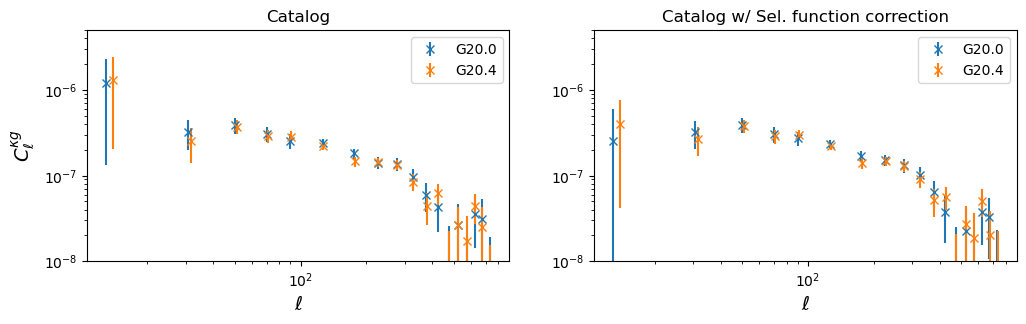

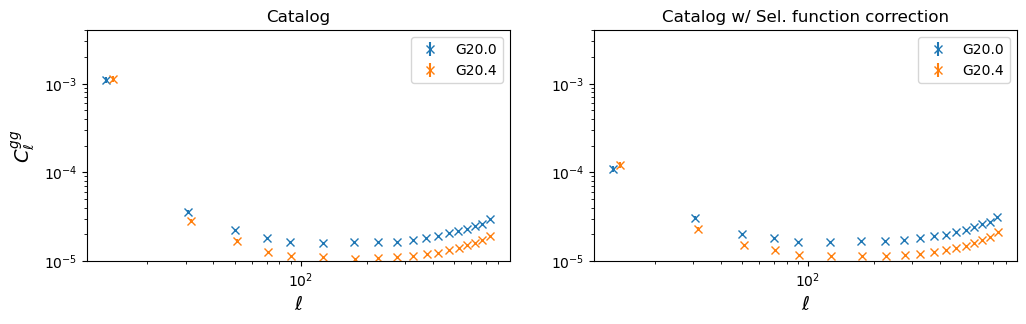

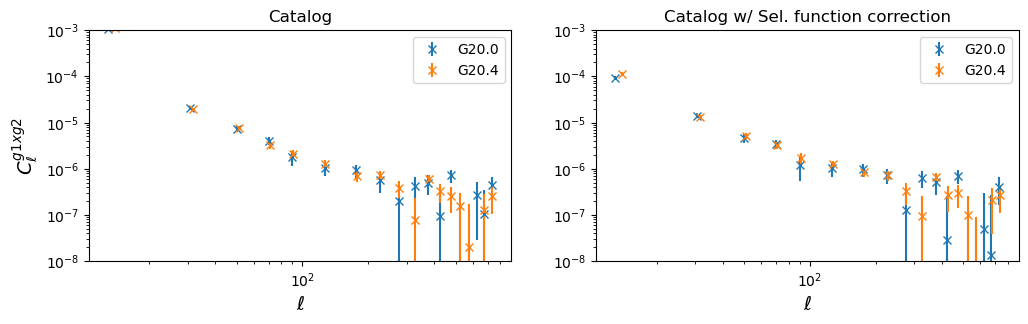

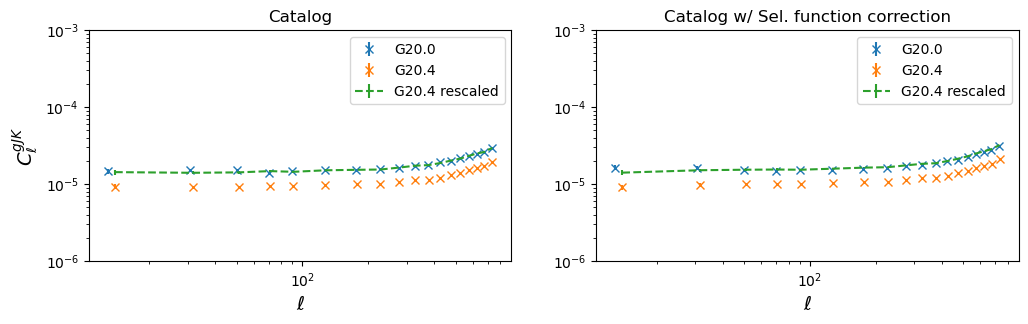

In [746]:
fsize = (12,3)

f,ax = pl.subplots(1,2,figsize=fsize )
for i in [70]:
    ax[0].errorbar(cls_dict[20]['ls'],cls_dict[20][i]['cls'][0][0],cls_dict[20][i]['cls'][1][0],marker='x',ls='',label='G20.0')
    ax[0].errorbar(cls_dict[20]['ls']+1,cls_dict[20][i]['cls_204'][0][0],cls_dict[20][i]['cls_204'][1][0],marker='x',ls='',label='G20.4')    
    ax[1].errorbar(cls_dict[20]['ls'],cls_dict[20][i]['cls_sel'][0][0],cls_dict[20][i]['cls_sel'][1][0],marker='x',ls='',label='G20.0')
    ax[1].errorbar(cls_dict[20]['ls']+1,cls_dict[20][i]['cls_204_sel'][0][0],cls_dict[20][i]['cls_204_sel'][1][0],marker='x',ls='',label='G20.4')
for k in range(2):
    ax[k].legend()
    ax[k].set_yscale("log")
    ax[k].set_xscale("log")
    ax[k].set_ylim(1e-08,5e-06)
    ax[k].set_xlabel("$\ell$",size=14)    
ax[0].set_ylabel("$C_\ell^{\kappa g}$",size=14)
ax[0].set_title("Catalog")
ax[1].set_title("Catalog w/ Sel. function correction")
pl.show()


f,ax = pl.subplots(1,2,figsize=fsize)
for i in [70]:
    ax[0].errorbar(cls_dict[20]['ls'],cls_dict[20][i]['cls'][0][1],cls_dict[20][i]['cls'][1][1],marker='x',ls='',label='G20.0')
    ax[0].errorbar(cls_dict[20]['ls']+1,cls_dict[20][i]['cls_204'][0][1],cls_dict[20][i]['cls_204'][1][1],marker='x',ls='',label='G20.4')    
    ax[1].errorbar(cls_dict[20]['ls'],cls_dict[20][i]['cls_sel'][0][1],cls_dict[20][i]['cls_sel'][1][1],marker='x',ls='',label='G20.0')
    ax[1].errorbar(cls_dict[20]['ls']+1,cls_dict[20][i]['cls_204_sel'][0][1],cls_dict[20][i]['cls_204_sel'][1][1],marker='x',ls='',label='G20.4')
for k in range(2):
    ax[k].legend()
    ax[k].set_yscale("log")
    ax[k].set_xscale("log")
    ax[k].set_ylim(1e-05,4e-03)
    ax[k].set_xlabel("$\ell$",size=14)    
ax[0].set_ylabel("$C_\ell^{gg}$",size=14)  
ax[0].set_title("Catalog")
ax[1].set_title("Catalog w/ Sel. function correction") 
pl.show()

f,ax = pl.subplots(1,2,figsize=fsize)
for i in [70]:
    ax[0].errorbar(cls_dict[20]['ls'],cls_dict[20][i]['cls'][0][7],cls_dict[20][i]['cls'][1][7],marker='x',ls='',label='G20.0')
    ax[0].errorbar(cls_dict[20]['ls']+1,cls_dict[20][i]['cls_204'][0][7],cls_dict[20][i]['cls_204'][1][7],marker='x',ls='',label='G20.4')    
    ax[1].errorbar(cls_dict[20]['ls'],cls_dict[20][i]['cls_sel'][0][7],cls_dict[20][i]['cls_sel'][1][7],marker='x',ls='',label='G20.0')
    ax[1].errorbar(cls_dict[20]['ls']+1,cls_dict[20][i]['cls_204_sel'][0][7],cls_dict[20][i]['cls_204_sel'][1][7],marker='x',ls='',label='G20.4')
for k in range(2):
    ax[k].legend()
    ax[k].set_yscale("log")
    ax[k].set_xscale("log")
    ax[k].set_ylim(1e-08,1e-03)
    ax[k].set_xlabel("$\ell$",size=14)    
ax[0].set_ylabel("$C_\ell^{g1xg2}$",size=14)    
ax[0].set_title("Catalog")
ax[1].set_title("Catalog w/ Sel. function correction") 
pl.show() 

f,ax = pl.subplots(1,2,figsize=fsize)
for i in [70]:
    ax[0].errorbar(cls_dict[20]['ls'],cls_dict[20][i]['cls'][0][-1],cls_dict[20][i]['cls'][1][-1],marker='x',ls='',label='G20.0')
    ax[0].errorbar(cls_dict[20]['ls']+1,cls_dict[20][i]['cls_204'][0][-1],cls_dict[20][i]['cls_204'][1][-1],marker='x',ls='',label='G20.4')    
    ax[0].errorbar(cls_dict[20]['ls']+1,cls_dict[20][i]['cls_204'][0][-1]*nqso204/nqso,cls_dict[20][i]['cls_204'][1][-1]*nqso204/nqso,marker='',ls='--',label='G20.4 rescaled')        

    ax[1].errorbar(cls_dict[20]['ls'],cls_dict[20][i]['cls_sel'][0][-1],cls_dict[20][i]['cls_sel'][1][-1],marker='x',ls='',label='G20.0')
    ax[1].errorbar(cls_dict[20]['ls']+1,cls_dict[20][i]['cls_204_sel'][0][-1],cls_dict[20][i]['cls_204_sel'][1][-1],marker='x',ls='',label='G20.4')
    ax[1].errorbar(cls_dict[20]['ls']+1,cls_dict[20][i]['cls_204_sel'][0][-1]*nqso204/nqso,cls_dict[20][i]['cls_204_sel'][1][-1]*nqso204/nqso,marker='',ls='--',label='G20.4 rescaled')            
for k in range(2):
    ax[k].legend()
    ax[k].set_yscale("log")
    ax[k].set_xscale("log")
    ax[k].set_ylim(1e-06,1e-03)
    ax[k].set_xlabel("$\ell$",size=14)    
ax[0].set_ylabel("$C_\ell^{gJK}$",size=14)
ax[0].set_title("Catalog")
ax[1].set_title("Catalog w/ Sel. function correction")    
pl.show() 


## Binning & weightings effect

I use different strategies to minimize the systematics. 
1) Do nothing.
2) I use the selection function as spatial weight in the power spectrum computation (label w in the plots)
3) I correct the counts map dividing out the selection function prior to the computation of the power spectra (sel. func. corr. label in plots).
4) I use the weighting of 2) on the map computed by 3)

The major results are 
* The $C_\ell^{\kappa g}$ is weakly sensitive to any of the weighting scheme reinforcing the robustness of this measurements w.r.t. systematics. Only he first bin shifts down by a little. The error bars are also slightly reduced. 
* For anything involving $g$, option 2) slighlty improves but the game changer is the selection function correction of option 3) as it stabilizes the power spectrum computation and also a re-weighting as in 4) as little effect on the bandpowers.
* For improvement in the previous point I focus on decrease in power in the first few bins. Anything above $\ell\gtr 50$ is virtually insensitive to the weighting scheme. 

I used different multipole binnings to bin the spectra and the mode-mixing matrix in the power spectrum computation in particular at large scales. The binnings I used adopt

* $\Delta\ell=50$  for $\ell\geq 100$ and 
* $\Delta\ell=20$ (baseline case, left plots) and $\Delta\ell=10$ (right plots) for $\ell<100$. 

The $\Delta\ell=10$ option should tell us if the increase in power at large scale is confined in particular to the very largest scales. Take home message is that it doesn't seem to be the case as the $\Delta\ell=20$ bins seem to be an average of the first two bins in the $\Delta\ell=10$ cases.

A quadratic maximum likelihood power spectrum estimator should be adopted for the very largest scales as it would minimize the coupling and gaussianizes the likelihood of the $C_\ell$s at large scales. If we resolve the multipoles $\ell$-by-$\ell$ we can then eventually cut out single multipoles that are problematic / inconsistent with the noise model.



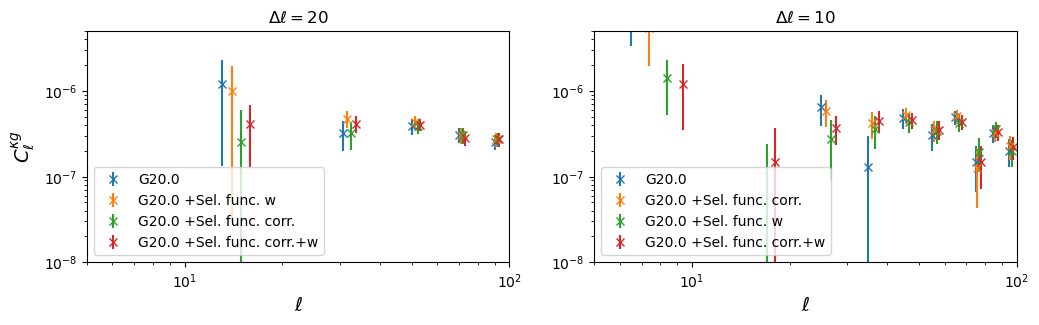

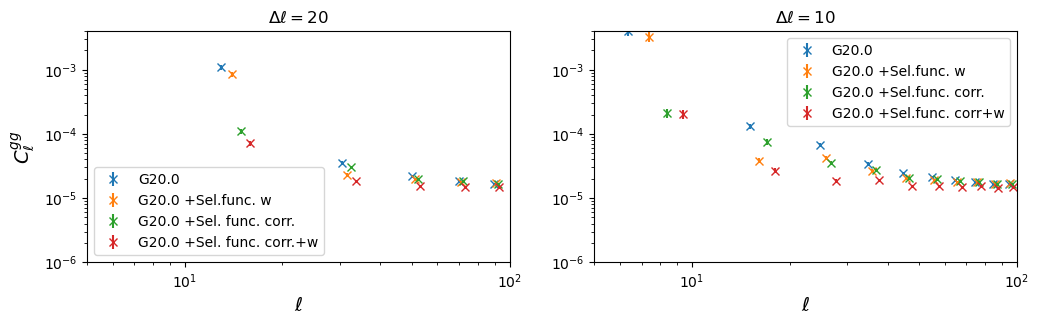

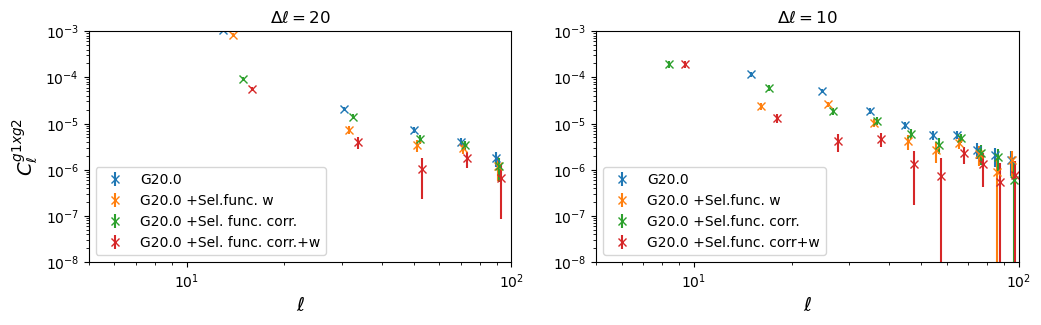

In [747]:
f,ax = pl.subplots(1,2,figsize=fsize)
for i in [70]:
    ax[0].errorbar(cls_dict[20]['ls']+0.1,cls_dict[20][i]['cls'][0][0],cls_dict[20][i]['cls'][1][0],
                   marker='x',ls='',label='G20.0')
    ax[0].errorbar(cls_dict[20]['ls']+1,cls_dict[20][i]['cls_wmask'][0][0],cls_dict[20][i]['cls_wmask'][1][0],
                   marker='x',ls='',label='G20.0 +Sel. func. w')
    ax[0].errorbar(cls_dict[20]['ls']+2,cls_dict[20][i]['cls_sel'][0][0],cls_dict[20][i]['cls_sel'][1][0],
                   marker='x',ls='',label='G20.0 +Sel. func. corr.')
    ax[0].errorbar(cls_dict[20]['ls']+3,cls_dict[20][i]['cls_sel_wmask'][0][0],cls_dict[20][i]['cls_sel_wmask'][1][0],
                   marker='x',ls='',label='G20.0 +Sel. func. corr.+w')
    
    

    ax[1].errorbar(cls_dict[10]['ls']+0.1,cls_dict[10][i]['cls'][0][0],cls_dict[10][i]['cls'][1][0],
                   marker='x',ls='',label='G20.0')
    ax[1].errorbar(cls_dict[10]['ls']+1,cls_dict[10][i]['cls_wmask'][0][0],cls_dict[10][i]['cls_wmask'][1][0],
                   marker='x',ls='',label='G20.0 +Sel. func. corr.')
    ax[1].errorbar(cls_dict[10]['ls']+2,cls_dict[10][i]['cls_sel'][0][0],cls_dict[10][i]['cls_sel'][1][0],
                   marker='x',ls='',label='G20.0 +Sel. func. w')
    ax[1].errorbar(cls_dict[10]['ls']+3,cls_dict[10][i]['cls_sel_wmask'][0][0],cls_dict[10][i]['cls_sel_wmask'][1][0],
                   marker='x',ls='',label='G20.0 +Sel. func. corr.+w')
    
for k in range(2):
    ax[k].legend()
    ax[k].set_yscale("log")
    ax[k].set_xscale("log")
    ax[k].set_xlabel("$\ell$",size=14)    
    #ax[k].set_ylim(1e-06,4e-03)    
    ax[k].set_ylim(1e-08,5e-06)   
    ax[k].set_xlim(5,100)       
#ax[1].set_ylabel("$C_\ell^{gg}$",size=14)    
ax[0].set_ylabel("$C_\ell^{\kappa g}$",size=14)    
ax[0].set_title("$\Delta \ell = 20$")
ax[1].set_title("$\Delta \ell = 10$")
pl.show() 

f,ax = pl.subplots(1,2,figsize=fsize)
for i in [70]:
    ax[0].errorbar(cls_dict[20]['ls'],cls_dict[20][i]['cls'][0][1],cls_dict[20][i]['cls'][1][1],
                   marker='x',ls='',label='G20.0')
    ax[0].errorbar(cls_dict[20]['ls']+1,cls_dict[20][i]['cls_wmask'][0][1],cls_dict[20][i]['cls_wmask'][1][1],
                   marker='x',ls='',label='G20.0 +Sel.func. w')
    ax[0].errorbar(cls_dict[20]['ls']+2,cls_dict[20][i]['cls_sel'][0][1],cls_dict[20][i]['cls_sel'][1][1],
                   marker='x',ls='',label='G20.0 +Sel. func. corr.')
    ax[0].errorbar(cls_dict[20]['ls']+3,cls_dict[20][i]['cls_sel_wmask'][0][1],
                   cls_dict[20][i]['cls_sel_wmask'][1][1],marker='x',ls='',label='G20.0 +Sel. func. corr.+w')
    
    
    ax[1].errorbar(cls_dict[10]['ls'],cls_dict[10][i]['cls'][0][1],cls_dict[10][i]['cls'][1][1],
                   marker='x',ls='',label='G20.0')
    ax[1].errorbar(cls_dict[10]['ls']+1,cls_dict[10][i]['cls_wmask'][0][1],cls_dict[10][i]['cls_wmask'][1][1],
                   marker='x',ls='',label='G20.0 +Sel.func. w')
    ax[1].errorbar(cls_dict[10]['ls']+2,cls_dict[10][i]['cls_sel'][0][1],cls_dict[10][i]['cls_sel'][1][1],
                   marker='x',ls='',label='G20.0 +Sel.func. corr.')
    ax[1].errorbar(cls_dict[10]['ls']+3,cls_dict[10][i]['cls_sel_wmask'][0][1],
                   cls_dict[10][i]['cls_sel_wmask'][1][1],marker='x',ls='',label='G20.0 +Sel.func. corr+w')
    
for k in range(2):
    ax[k].legend(loc='best')
    ax[k].set_yscale("log")
    ax[k].set_xscale("log")
    ax[k].set_xlabel("$\ell$",size=14)    
    ax[k].set_ylim(1e-06,4e-03)   
    ax[k].set_xlim(5,100)          
    ax[k].set_title("$\delta \ell = 10")    
ax[0].set_ylabel("$C_\ell^{gg}$",size=14)
#ax[0].set_ylabel("$C_\ell^{\kappa g}$",size=14)    
ax[0].set_title("$\Delta \ell = 20$")
ax[1].set_title("$\Delta \ell = 10$")
pl.show() 


f,ax = pl.subplots(1,2,figsize=fsize)
for i in [70]:
    ax[0].errorbar(cls_dict[20]['ls'],cls_dict[20][i]['cls'][0][7],cls_dict[20][i]['cls'][1][7],
                   marker='x',ls='',label='G20.0')
    ax[0].errorbar(cls_dict[20]['ls']+1,cls_dict[20][i]['cls_wmask'][0][7],cls_dict[20][i]['cls_wmask'][1][7],
                   marker='x',ls='',label='G20.0 +Sel.func. w')
    ax[0].errorbar(cls_dict[20]['ls']+2,cls_dict[20][i]['cls_sel'][0][7],cls_dict[20][i]['cls_sel'][1][7],
                   marker='x',ls='',label='G20.0 +Sel. func. corr.')
    ax[0].errorbar(cls_dict[20]['ls']+3,cls_dict[20][i]['cls_sel_wmask'][0][7],
                   cls_dict[20][i]['cls_sel_wmask'][1][7],marker='x',ls='',label='G20.0 +Sel. func. corr.+w')
    
    
    ax[1].errorbar(cls_dict[10]['ls'],cls_dict[10][i]['cls'][0][7],cls_dict[10][i]['cls'][1][7],
                   marker='x',ls='',label='G20.0')
    ax[1].errorbar(cls_dict[10]['ls']+1,cls_dict[10][i]['cls_wmask'][0][7],cls_dict[10][i]['cls_wmask'][1][7],
                   marker='x',ls='',label='G20.0 +Sel.func. w')
    ax[1].errorbar(cls_dict[10]['ls']+2,cls_dict[10][i]['cls_sel'][0][7],cls_dict[10][i]['cls_sel'][1][7],
                   marker='x',ls='',label='G20.0 +Sel.func. corr.')
    ax[1].errorbar(cls_dict[10]['ls']+3,cls_dict[10][i]['cls_sel_wmask'][0][7],
                   cls_dict[10][i]['cls_sel_wmask'][1][7],marker='x',ls='',label='G20.0 +Sel.func. corr+w')
    
for k in range(2):
    ax[k].legend(loc='best')
    ax[k].set_yscale("log")
    ax[k].set_xscale("log")
    ax[k].set_xlabel("$\ell$",size=14)    
    ax[k].set_ylim(1e-08,1e-03)   
    ax[k].set_xlim(5,100)          
    ax[k].set_title("$\delta \ell = 10")    
ax[0].set_ylabel("$C_\ell^{g1xg2}$",size=14)
#ax[0].set_ylabel("$C_\ell^{\kappa g}$",size=14)    
ax[0].set_title("$\Delta \ell = 20$")
ax[1].set_title("$\Delta \ell = 10$")
pl.show() 


## Point source masking effect

Here I compare the results of the baseline footprint with those obtained masking some point sources (i.e. the magellanic cloud) or other radio galaxies excluded in the lensing reconstruciton (lensing mask). The results are stable for $\kappa g$ but the Magellanic cloud seem to have some effect in the second bin in the $g_1g_2$ spectrum. So we should remove those. The lensing mask has a similar result as the Magellanic cloud mask.

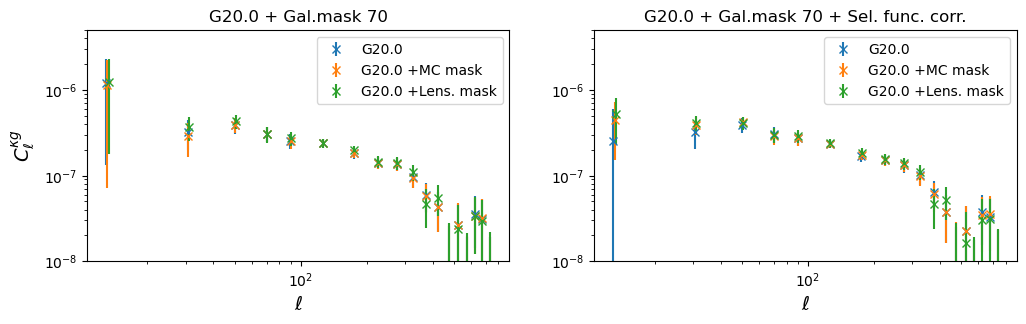

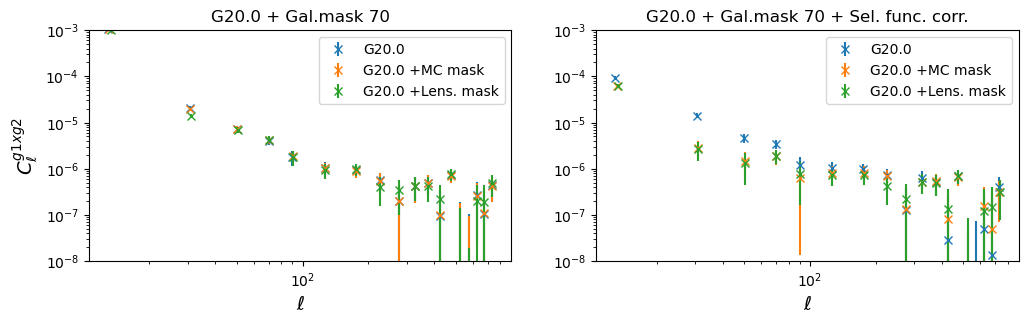

In [748]:
f,ax = pl.subplots(1,2,figsize=fsize)
for i in [70]:
    ax[0].errorbar(cls_dict[20]['ls'],cls_dict[20][i]['cls'][0][0],cls_dict[20][i]['cls'][1][0],
                   marker='x',ls='',label='G20.0')
    ax[0].errorbar(cls_dict_mcmask[20]['ls']+0.2,cls_dict_mcmask[20][i]['cls'][0][0],cls_dict_mcmask[20][i]['cls'][1][0],
                   marker='x',ls='',label='G20.0 +MC mask')
    ax[0].errorbar(cls_dict_lensmask[20]['ls']+0.4,cls_dict_lensmask[20][i]['cls'][0][0],cls_dict_lensmask[20][i]['cls'][1][0],
                   marker='x',ls='',label='G20.0 +Lens. mask')    
    
    ax[1].errorbar(cls_dict[20]['ls'],cls_dict[20][i]['cls_sel'][0][0],cls_dict[20][i]['cls_sel'][1][0],
                   marker='x',ls='',label='G20.0')
    ax[1].errorbar(cls_dict_mcmask[20]['ls']+0.2,cls_dict_mcmask[20][i]['cls_sel'][0][0],cls_dict_mcmask[20][i]['cls_sel'][1][0],
                   marker='x',ls='',label='G20.0 +MC mask')
    ax[1].errorbar(cls_dict_lensmask[20]['ls']+0.4,cls_dict_lensmask[20][i]['cls_sel'][0][0],cls_dict_lensmask[20][i]['cls_sel'][1][0],
                   marker='x',ls='',label='G20.0 +Lens. mask')    
for k in range(2):
    ax[k].legend()
    ax[k].set_yscale("log")
    ax[k].set_xscale("log")
    ax[k].set_xlabel("$\ell$",size=14)    
    #ax[k].set_ylim(1e-06,4e-03)    
    ax[k].set_ylim(1e-08,5e-06)      
ax[0].set_ylabel("$C_\ell^{\kappa g}$",size=14)    
ax[0].set_title("G20.0 + Gal.mask 70")
ax[1].set_title("G20.0 + Gal.mask 70 + Sel. func. corr.")
pl.show()

f,ax = pl.subplots(1,2,figsize=fsize)
for i in [70]:
    ax[0].errorbar(cls_dict[20]['ls'],cls_dict[20][i]['cls'][0][7],cls_dict[20][i]['cls'][1][7],
                   marker='x',ls='',label='G20.0')
    ax[0].errorbar(cls_dict_mcmask[20]['ls']+0.2,cls_dict_mcmask[20][i]['cls'][0][7],cls_dict_mcmask[20][i]['cls'][1][7],
                   marker='x',ls='',label='G20.0 +MC mask')
    ax[0].errorbar(cls_dict_lensmask[20]['ls']+0.4,cls_dict_lensmask[20][i]['cls'][0][7],cls_dict_lensmask[20][i]['cls'][1][7],
                   marker='x',ls='',label='G20.0 +Lens. mask')    

    ax[1].errorbar(cls_dict[20]['ls'],cls_dict[20][i]['cls_sel'][0][7],cls_dict[20][i]['cls_sel'][1][7],
                   marker='x',ls='',label='G20.0')
    ax[1].errorbar(cls_dict_mcmask[20]['ls']+0.2,cls_dict_mcmask[20][i]['cls_sel'][0][7],cls_dict_mcmask[20][i]['cls_sel'][1][7],
                   marker='x',ls='',label='G20.0 +MC mask') 
    ax[1].errorbar(cls_dict_lensmask[20]['ls']+0.4,cls_dict_lensmask[20][i]['cls_sel'][0][7],cls_dict_lensmask[20][i]['cls_sel'][1][7],
                   marker='x',ls='',label='G20.0 +Lens. mask') 
    
for k in range(2):
    ax[k].legend()
    ax[k].set_yscale("log")
    ax[k].set_xscale("log")
    ax[k].set_xlabel("$\ell$",size=14)    
    #ax[k].set_ylim(1e-06,4e-03)    
    ax[k].set_ylim(1e-08,1e-03)      
ax[0].set_ylabel("$C_\ell^{g1xg2}$",size=14)    
ax[0].set_title("G20.0 + Gal.mask 70")
ax[1].set_title("G20.0 + Gal.mask 70 + Sel. func. corr.")
pl.show()


## Summary

We need to mask the magellanic clouds and apply the selection function correction as final strategy of our measurements. A binning scheme of $\Delta 20$ seems very stable but we may want to improve the largest scales with QML estimates. 

# Random catalog Monte Carlo catalog analysis 

Since the random catalog contains 10x the number of objects, I randomly split it in 10 catalogs and compute the mean and standar deviations of all the relevant power spectra to check their properties and statistics. I also use them to validate the auto spectrum measurements with theory predictions from CAMB.

In [528]:
# reshuffles the random catalog according to a re-indexing array then splits the catalog in 10 sub catalog and
# compute maps and power spectra with each subsample. 
# if a theory cls is provided, add a realization of the clustering to the overdensity map.
def process_masklist_mc(mask_list,mask_labels,split_reshuffle_rnd,dbins=[10,20],cl_theory=None):
    cls_dict={k:{} for k in dbins}
    cls_dict['info']='clkg,clgg,clkk,clkg1,clg1g1,clkg2,clg2g2,clg1g2,clkgjk,clgjk'
    cls_mc=[]
    cls_sel_mc=[]
    
    mrndsel_mc=np.zeros(hp.nside2npix(nside))
    mrnd2sel_mc=np.zeros(hp.nside2npix(nside))
    mrnd1sel_mc=np.zeros(hp.nside2npix(nside))
    
    lmc = (gsrnd.l.value[split_reshuffle_rnd])
    bmc = (gsrnd.b.value[split_reshuffle_rnd])
    

    for gmask_label,gmask in zip(mask_labels,mask_list):
        apomask = nmt.mask_apodization(gmask,2., apotype="C2")
        goodpix = gmask>0
        print("Processing mask",gmask_label)
        for dbin in dbins:
            cls_dict[dbin][gmask_label]={'cls':[], 'cls_sel':[]}
        for i in range(0,10):
            if cl_theory is None:
                g=0.
            else:
                g = hp.synfast(cl_theory[0:lmax],nside,pol=False,pixwin=True)
            mrnd_mc = make_counts(nside,lmc[i*nqso:(i+1)*nqso],gsrnd.b.value[i*nqso:(i+1)*nqso])
            mrnd1_mc = make_counts(nside,(lmc[i*nqso:(i+1)*nqso])[0::2],(bmc[i*nqso:(i+1)*nqso])[0::2])
            mrnd2_mc = make_counts(nside,(lmc[i*nqso:(i+1)*nqso])[1::2],(bmc[i*nqso:(i+1)*nqso])[1::2])   
                
            crnd_mc = overdensity_from_counts(mrnd_mc,goodpix,verbose=False) + g
            crnd1_mc = overdensity_from_counts(mrnd1_mc,goodpix,verbose=False) + g
            crnd2_mc = overdensity_from_counts(mrnd2_mc,goodpix,verbose=False) + g   
            jkrnd_mc = (crnd2_mc-crnd1_mc)/2      
            
            
            mrndsel_mc[binmask!=0] = mrnd_mc[binmask!=0]/mask[binmask!=0]
            mrnd1sel_mc[binmask!=0] = mrnd1_mc[binmask!=0]/mask[binmask!=0]
            mrnd2sel_mc[binmask!=0] = mrnd2_mc[binmask!=0]/mask[binmask!=0]       
        
            
            cselrnd_mc = overdensity_from_counts(mrndsel_mc,goodpix,verbose=False) + g 
            c1selrnd_mc = overdensity_from_counts(mrnd1sel_mc,goodpix,verbose=False) + g
            c2selrnd_mc = overdensity_from_counts(mrnd2sel_mc,goodpix,verbose=False) + g
            jkselrnd_mc =(c2selrnd_mc-c1selrnd_mc)/2      
            
            for dbin in dbins:
                binning = get_custom_binning(dbin)
                lb = binning.get_effective_ells()           
                cls_dict[dbin][gmask_label]['cls'].append(process_mask(klr,crnd_mc,crnd1_mc,crnd2_mc,jkrnd_mc,
                                                                apomask,binning,return_error = False))
                cls_dict[dbin][gmask_label]['cls_sel'].append(process_mask(klr,cselrnd_mc,c1selrnd_mc,c2selrnd_mc,
                                                                jkselrnd_mc,apomask,binning,return_error = False))
                cls_dict[dbin]['ls']=lb

            mrndsel_mc[:]=0.
            mrnd1sel_mc[:]=0.
            mrnd2sel_mc[:]=0.
                                                          
        cls_dict[dbin][gmask_label]['cls']=np.array(cls_dict[dbin][gmask_label]['cls'])    
        cls_dict[dbin][gmask_label]['cls_sel']=np.array(cls_dict[dbin][gmask_label]['cls_sel'])
    cls_dict['info']='binning->mask-> data->[clkg,clgg,clkk,clkg1,clg1g1,clkg2,clg2g2,clg1g2,clkgjk,clgjk]' 
    return cls_dict

In [394]:
try:
    with open("../cls_analysis_rnd_dict.pkl","rb") as f:
        cls_rnd_dict=pkl.load(f)
except:
    mask_list = [galmask80_lr,galmask70_lr,galmask60_lr,galmask50_lr,galmask40_lr,galmask20_lr]
    mask_labels = [80,70,60,50,40,20]
    dbins = [10,20]    
    cls_rnd_dict = process_masklist_mc(mask_list,mask_labels,split_reshuffle_rnd,dbins=[10,20])
    with open("../cls_analysis_rnd_dict.pkl","wb") as f:
        pkl.dump(cls_rnd_dict,f)   

Processing mask 80
Processing mask 70
Processing mask 60
Processing mask 50
Processing mask 40
Processing mask 20


In [460]:
try:
    with open("../cls_analysis_rnd_mcmask_dict.pkl","rb") as f:
        cls_rnd_mcmask_dict=pkl.load(f)
except:
    mask_list = [galmask80_lr*mclouds_mask,galmask70_lr*mclouds_mask,galmask60_lr*mclouds_mask,
                 galmask50_lr*mclouds_mask,galmask40_lr*mclouds_mask,galmask20_lr*mclouds_mask]
    mask_labels = [80,70,60,50,40,20]
    dbins = [10,20]    
    cls_rnd_mcmask_dict = process_masklist_mc(mask_list,mask_labels,split_reshuffle_rnd,dbins=[10,20])
    with open("../cls_analysis_rnd_mcmask_dict.pkl","wb") as f:
        pkl.dump(cls_rnd_mcmask_dict,f)  

Processing mask 80
Processing mask 70
Processing mask 60
Processing mask 50
Processing mask 40
Processing mask 20


In [461]:
try:
    with open("../cls_analysis_rnd_lensmask_dict.pkl","rb") as f:
        cls_rnd_lensmask_dict=pkl.load(f)
except:
    mask_list = [galmask80_lr*lensmask_lr,galmask70_lr*lensmask_lr,galmask60_lr*lensmask_lr,
                 galmask50_lr*lensmask_lr,galmask40_lr*lensmask_lr,galmask20_lr*lensmask_lr]
    mask_labels = [80,70,60,50,40,20]
    dbins = [10,20]    
    cls_rnd_lensmask_dict = process_masklist_mc(mask_list,mask_labels,split_reshuffle_rnd,dbins=[10,20])
    with open("../cls_analysis_rnd_lensmask_dict.pkl","wb") as f:
        pkl.dump(cls_rnd_lensmask_dict,f)  

Processing mask 80
Processing mask 70
Processing mask 60
Processing mask 50
Processing mask 40
Processing mask 20


## Results for the galaxy field

I show the mean and std of some power spectra for different masks $fsky=20$ on the left and $fsky=70$ on the right. Some noticeable features
* For the fksy=20 case the data and the simulations are insensitive to the selection function correction. The mean of the $g_1g_2$ spectrum is consistent with 0. 
* The fsky=70 case, the random catalog display high power at large scales consistent with residual correlation in the splits. If we apply the selection function correction the $g_1g_2$ spectrum is consistent with 0 suggesting that the estimate accounting for the correlation function is correct (TBD a mock with noise and random realization of the clustering part to check that we can recover it correctly)
* The $gg$ spectrum is consistent with shot noise once the selection function correction is applied for fsky=70 case. The fsky=20 case is always ok. 
* The data are consistent with the random catalog as the clustering is subdominant but some discrepancies are seen still for fsky=20 case and $\ell<40$ and fsky=70 case for $\ell<80$.

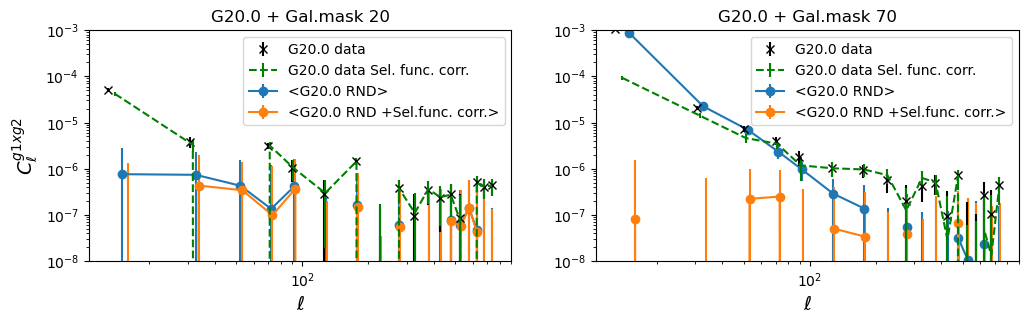

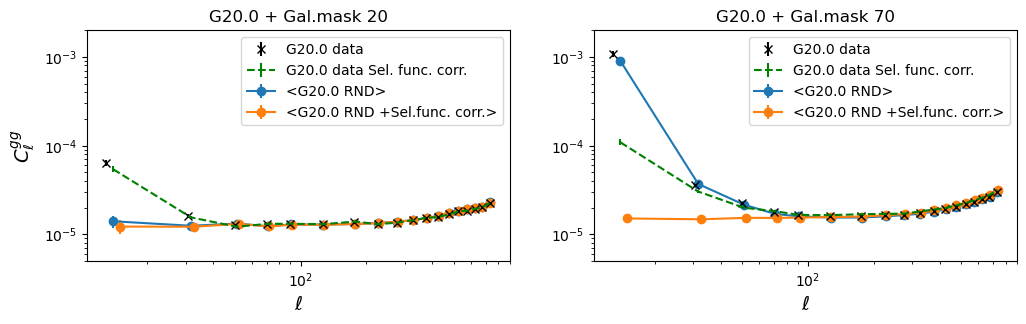

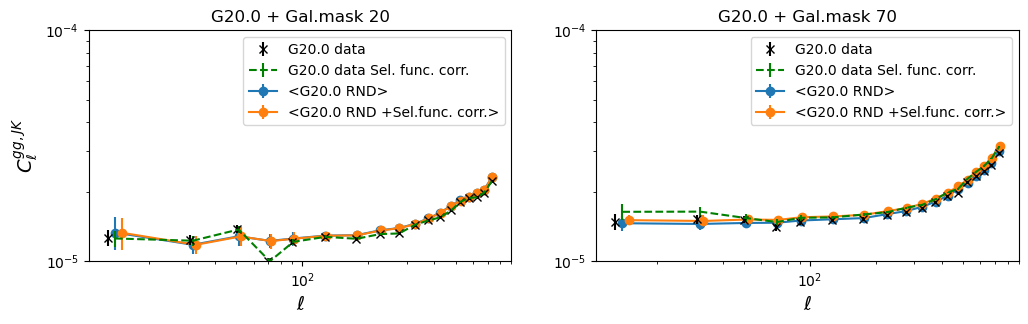

In [749]:

f,ax = pl.subplots(1,2,figsize=fsize)
for j,i in enumerate([20,70]):
    ax[j].errorbar(cls_dict[20]['ls'],cls_dict[20][i]['cls'][0][7],cls_dict[20][i]['cls'][1][7],
                   marker='x',ls='',label='G20.0 data',color='black',zorder=3)
    ax[j].errorbar(cls_dict[20]['ls']+1,cls_dict[20][i]['cls_sel'][0][7],cls_dict[20][i]['cls_sel'][1][7],
                   marker='',ls='--',label='G20.0 data Sel. func. corr.',color='green',zorder=3)
    
    ax[j].errorbar(cls_dict[20]['ls']+2,np.mean(cls_rnd_dict[20][i]['cls'],axis=0)[7],
                   np.std(cls_rnd_dict[20][i]['cls'],axis=0)[7],marker='o',label='<G20.0 RND>')    
    ax[j].errorbar(cls_dict[20]['ls']+3,np.mean(cls_rnd_dict[20][i]['cls_sel'],axis=0)[7],
                   np.std(cls_rnd_dict[20][i]['cls_sel'],axis=0)[7],marker='o',label='<G20.0 RND +Sel.func. corr.>')     
    ax[j].set_title("G20.0 + Gal.mask %d"%i)    
for k in range(2):
    ax[k].legend()
    ax[k].set_yscale("log")
    ax[k].set_xscale("log")
    ax[k].set_xlabel("$\ell$",size=14)    
    #ax[k].set_ylim(1e-06,4e-03)    
    ax[k].set_ylim(1e-08,1e-03)      
ax[0].set_ylabel("$C_\ell^{g1xg2}$",size=14)    
pl.show()

f,ax = pl.subplots(1,2,figsize=fsize)
for j,i in enumerate([20,70]):
    ax[j].errorbar(cls_dict[20]['ls'],cls_dict[20][i]['cls'][0][1],cls_dict[20][i]['cls'][1][1],
                   marker='x',ls='',label='G20.0 data',color='black',zorder=3)
    ax[j].errorbar(cls_dict[20]['ls']+1,cls_dict[20][i]['cls_sel'][0][1],cls_dict[20][i]['cls_sel'][1][1],
                   marker='',ls='--',label='G20.0 data Sel. func. corr.',color='green',zorder=3)
    
    ax[j].errorbar(cls_dict[20]['ls']+1,np.mean(cls_rnd_dict[20][i]['cls'],axis=0)[1],
                   np.std(cls_rnd_dict[20][i]['cls'],axis=0)[1],marker='o',label='<G20.0 RND>')    
    ax[j].errorbar(cls_dict[20]['ls']+2,np.mean(cls_rnd_dict[20][i]['cls_sel'],axis=0)[1],
                   np.std(cls_rnd_dict[20][i]['cls_sel'],axis=0)[1],marker='o',label='<G20.0 RND +Sel.func. corr.>')     
    ax[j].set_title("G20.0 + Gal.mask %d"%i)    
for k in range(2):
    ax[k].legend()
    ax[k].set_yscale("log")
    ax[k].set_xscale("log")
    ax[k].set_xlabel("$\ell$",size=14)    
    #ax[k].set_ylim(1e-06,4e-03)    
    ax[k].set_ylim(5e-06,2e-03)      
ax[0].set_ylabel("$C_\ell^{gg}$",size=14)    
pl.show()


f,ax = pl.subplots(1,2,figsize=fsize)
for j,i in enumerate([20,70]):
    ax[j].errorbar(cls_dict[20]['ls'],cls_dict[20][i]['cls'][0][-1],cls_dict[20][i]['cls'][1][-1],
                   marker='x',ls='',label='G20.0 data',color='black',zorder=3)
    ax[j].errorbar(cls_dict[20]['ls']+1,cls_dict[20][i]['cls_sel'][0][-1],cls_dict[20][i]['cls_sel'][1][-1],
                   marker='',ls='--',label='G20.0 data Sel. func. corr.',color='green',zorder=3)
    
    ax[j].errorbar(cls_dict[20]['ls']+1,np.mean(cls_rnd_dict[20][i]['cls'],axis=0)[-1],
                   np.std(cls_rnd_dict[20][i]['cls'],axis=0)[-1],marker='o',label='<G20.0 RND>')    
    ax[j].errorbar(cls_dict[20]['ls']+2,np.mean(cls_rnd_dict[20][i]['cls_sel'],axis=0)[-1],
                   np.std(cls_rnd_dict[20][i]['cls_sel'],axis=0)[-1],marker='o',label='<G20.0 RND +Sel.func. corr.>')     
    ax[j].set_title("G20.0 + Gal.mask %d"%i)    
for k in range(2):
    ax[k].legend()
    ax[k].set_yscale("log")
    ax[k].set_xscale("log")
    ax[k].set_xlabel("$\ell$",size=14)    
    #ax[k].set_ylim(1e-06,4e-03)    
    ax[k].set_ylim(1e-05,1e-04)      
ax[0].set_ylabel("$C_\ell^{gg,JK}$",size=14)    
pl.show()


## Results with simulated clustering 

I repeat the tests above adding to the random realization of the catalog (that should be just shot-noise) a Gaussian random realization of the expected signal for the clustering as computed from CAMB assuming the $dn/dz$ of the catalog. 

I use two galactic masks ($f_{sky}=70%, 20%$ and the Magellanic cloud masks and compare the results with and without the selection function correction. In the plot I overlay the data measured with the same mask.

The results shows that 
1) the pipeline using $C_\ell^{g1xg2}$ shoudl recover the unbiased spectrum of $C_\ell^{gg}$ as computed from CAMB given that it doesn't have a noise bias in principle. 
2) The rough comparison of 1) with data also suggests that we can just discard the first bin of $C_\ell^{g1xg2}$ and use the rest for inference as it seems by eye very consistent with theory.
3) If we don't apply the selection function correction $C_\ell^{g1xg2}$ is biased on the largest scales since a residual noise correlation is retained and would need to be debiased with MC of noise alone. 
4) The test also shows that the extra power in the first bin for $\ell<20$ is clearly inconsistent with the noise model. I plot two different binning choices (first and second plot) and this conclusion holds also for a finer binning scheme. 
5) $C_\ell^{g1xg2}$ is still biased as the splitting retains correlation if we don't account for the selection function. This can be seen in particular for the $f_{sky}=70\%$ case where the effect is more important while the $f_{sky}=20%$ case does not have this bias as the servey is complete and the splitting of the sample leads to effectively independent subsamples. Debiasing $C_\ell^{g1xg2}$ with the mean of the Monte Carlo realizations including only noise gives again an unbiased spectrum. The debiasing affects only the largest scales as is visible in the first set of plots in the previous section. 
6) I repeated the same tests debiasing the auto spectrum of the galaxies with the jackknife noise i.e.  $C_\ell^{gg}-C_\ell^{gg,JK}$. This gives results consistent with theory too on Monte Carlo realizations. 

In [518]:
import camb
from camb import model, initialpower
from camb.sources import GaussianSourceWindow, SplinedSourceWindow


def init_pars(do_magnification_bias=False):

    pars = camb.CAMBparams()
    lmax=1000
    
    pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122, mnu=0)
    pars.InitPower.set_params(As=2e-9, ns=0.965)
    pars.set_for_lmax(lmax, lens_potential_accuracy=4)
    ##set Want_CMB to true if you also want CMB spectra or correlations
    pars.Want_CMB = True
    
    ##NonLinear_both or NonLinear_lens will use non-linear corrections
    pars.NonLinear = model.NonLinear_both
    
    #density only is the default
    pars.SourceTerms.limber_windows = True
    pars.SourceTerms.limber_phi_lmin = 200
    pars.SourceTerms.counts_lensing = do_magnification_bias  
    pars.SourceTerms.counts_density  = True
    pars.SourceTerms.counts_redshift = True #weird problems at times
    pars.SourceTerms.counts_radial   = True # negligible at l<10
    pars.SourceTerms.counts_timedelay = True # negligible
    pars.SourceTerms.counts_ISW = True #negligible
    pars.SourceTerms.counts_velocity = True #negligible
    pars.SourceTerms.counts_potential = True #negligible
    pars.SourceTerms.counts_evolve = True # not sure what this is
    
    pars.Accuracy.LensingBoost = 1.0
    pars.Accuracy.NonlinSourceBoost = 1.0
    pars.Accuracy.BesselBoost = 1.0
    pars.Accuracy.LimberBoost = 1.0
    pars.Accuracy.SourceLimberBoost = 1.0
    return pars 

pars = init_pars()
dndz= pl.hist(d[1].data['redshift_spz'],bins=50)
pl.close()
#dndz= pl.hist(d[1].data['redshift_qsoc'],bins=50)
dndz=[np.diff(dndz[1])+dndz[1][:-1],dndz[0]]

# read dn/dz and normalize it
dndz[1]/=np.trapz(dndz[1],dndz[0])
#pl.plot(dndz[0],dndz[1])

##Set up W(z) window functions, later labelled W1 from Gaia dN/dz function.
b_quasar=2.35
W=np.array(dndz[1])
z=np.array(dndz[0])
pars.SourceWindows = [SplinedSourceWindow(bias_z=b_quasar*np.ones(len(z)), z=z, W=W,source_type='counts',dlog10Ndm = 0.0)]

results = camb.get_results(pars)

#cmb = results.get_cmb_power_spectra(raw_cl=True,CMB_unit='muK')
cls = results.get_source_cls_dict(raw_cl=True) 



In [609]:
try:
    dasdsa
    with open("../cls_analysis_rnd_g_mcmask_dict.pkl","rb") as f:
        cls_rnd_g_mcmask_dict=pkl.load(f)
except:
    mask_list = [galmask80_lr*mclouds_mask,galmask70_lr*mclouds_mask,galmask60_lr*mclouds_mask,
                 galmask50_lr*mclouds_mask,galmask40_lr*mclouds_mask,galmask20_lr*mclouds_mask]
    mask_labels = [80,70,60,50,40,20]
    #mask_list = [galmask70_lr*mclouds_mask,galmask20_lr*mclouds_mask]
    #mask_labels = [70,20]
    dbins = [10,20]    
    cls_rnd_g_mcmask_dict = process_masklist_mc(mask_list,mask_labels,split_reshuffle_rnd,dbins=[10,20],cl_theory=cls['W1xW1'])
    with open("../cls_analysis_rnd_g_mcmask_dict.pkl","wb") as f:
        pkl.dump(cls_rnd_g_mcmask_dict,f)


Processing mask 80
Processing mask 70
Processing mask 60
Processing mask 50
Processing mask 40
Processing mask 20


g1Xg2 cross-spectrum


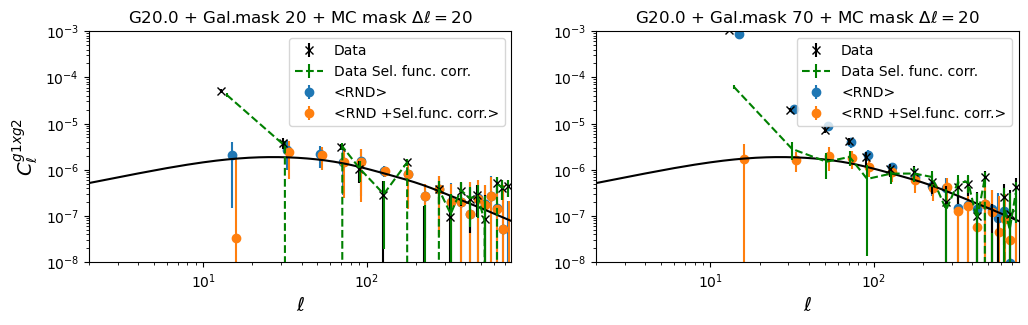

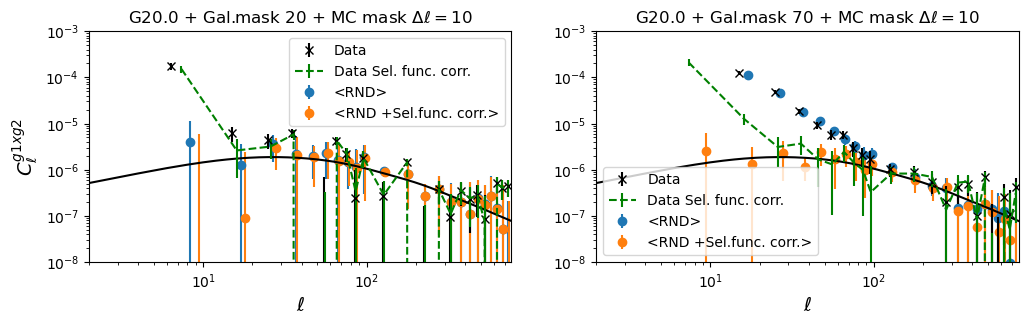

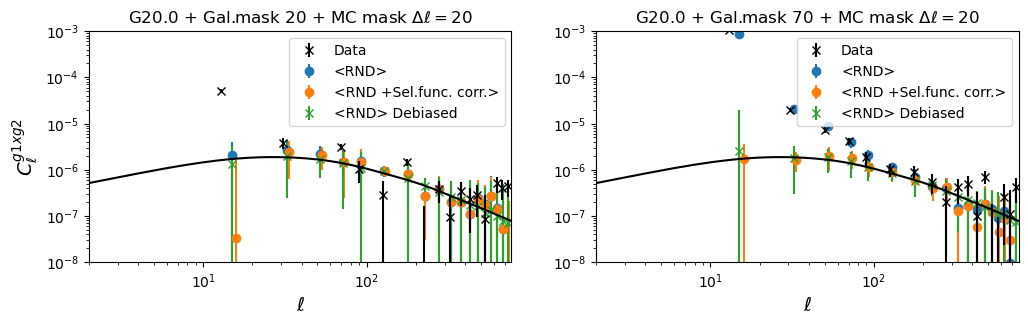

gg Auto spectrum


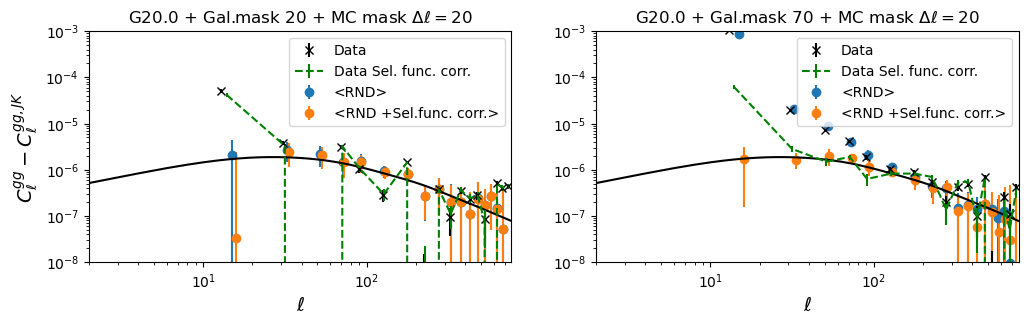

In [750]:
print ("g1Xg2 cross-spectrum")  
for dbin in [20,10]:
    f,ax = pl.subplots(1,2,figsize=fsize)
    for j,i in enumerate([20,70]):
        ax[j].errorbar(cls_dict_mcmask[dbin]['ls'],cls_dict_mcmask[dbin][i]['cls'][0][7],cls_dict_mcmask[dbin][i]['cls'][1][7],
                       marker='x',ls='',label='Data',color='black',zorder=3)
        ax[j].errorbar(cls_dict_mcmask[dbin]['ls']+1,cls_dict_mcmask[dbin][i]['cls_sel'][0][7],cls_dict_mcmask[dbin][i]['cls_sel'][1][7],
                       marker='',ls='--',label='Data Sel. func. corr.',color='green',zorder=3)
        
        ax[j].errorbar(cls_rnd_g_mcmask_dict[dbin]['ls']+2,np.mean(cls_rnd_g_mcmask_dict[dbin][i]['cls'],axis=0)[7],
                       np.std(cls_rnd_g_mcmask_dict[dbin][i]['cls'],axis=0)[7],marker='o',label='<RND>',ls='')    
        
        ax[j].errorbar(cls_rnd_g_mcmask_dict[dbin]['ls']+3,np.mean(cls_rnd_g_mcmask_dict[dbin][i]['cls_sel'],axis=0)[7],
                       np.std(cls_rnd_g_mcmask_dict[dbin][i]['cls_sel'],axis=0)[7],marker='o',
                       label='<RND +Sel.func. corr.>',ls='')                                              
        ax[j].set_title("G20.0 + Gal.mask %d + MC mask $\Delta\ell=%d$"%(i,dbin))   
        ax[j].errorbar(np.arange(len(cls['W1xW1'])),cls['W1xW1'],color='black')
    for k in range(2):
        ax[k].legend()
        ax[k].set_yscale("log")
        ax[k].set_xscale("log")
        ax[k].set_xlabel("$\ell$",size=14)    
        ax[k].set_ylim(1e-08,1e-03)  
        ax[k].set_xlim(2,lmax)
    ax[0].set_ylabel("$C_\ell^{g1xg2}$",size=14)    
    pl.show()
    
for dbin in [20]:
    f,ax = pl.subplots(1,2,figsize=fsize)
    for j,i in enumerate([20,70]):
        ax[j].errorbar(cls_dict_mcmask[dbin]['ls'],cls_dict_mcmask[dbin][i]['cls'][0][7],cls_dict_mcmask[dbin][i]['cls'][1][7],
                       marker='x',ls='',label='Data',color='black',zorder=3)
#        ax[j].errorbar(cls_dict_mcmask[dbin]['ls']+1,cls_dict_mcmask[dbin][i]['cls_sel'][0][7],cls_dict_mcmask[dbin][i]['cls_sel'][1][7],
#                       marker='',ls='--',label='Data Sel. func. corr.',color='green',zorder=3)
#        
        ax[j].errorbar(cls_rnd_g_mcmask_dict[dbin]['ls']+2,np.mean(cls_rnd_g_mcmask_dict[dbin][i]['cls'],axis=0)[7],
                       np.std(cls_rnd_g_mcmask_dict[dbin][i]['cls'],axis=0)[7],marker='o',label='<RND>',ls='')    
        
        ax[j].errorbar(cls_rnd_g_mcmask_dict[dbin]['ls']+3,np.mean(cls_rnd_g_mcmask_dict[dbin][i]['cls_sel'],axis=0)[7],
                       np.std(cls_rnd_g_mcmask_dict[dbin][i]['cls_sel'],axis=0)[7],marker='o',
                       label='<RND +Sel.func. corr.>',ls='')     
        ax[j].errorbar(cls_rnd_g_mcmask_dict[dbin]['ls']+2,np.mean(cls_rnd_g_mcmask_dict[dbin][i]['cls'],axis=0)[7]
                   - np.mean(cls_rnd_mcmask_dict[dbin][i]['cls'],axis=0)[7],
                   np.std(cls_rnd_g_mcmask_dict[dbin][i]['cls'],axis=0)[7],marker='x',label='<RND> Debiased',
                       ls='')                                          
        ax[j].set_title("G20.0 + Gal.mask %d + MC mask $\Delta\ell=%d$"%(i,dbin))   
        ax[j].errorbar(np.arange(len(cls['W1xW1'])),cls['W1xW1'],color='black')
    for k in range(2):
        ax[k].legend()
        ax[k].set_yscale("log")
        ax[k].set_xscale("log")
        ax[k].set_xlabel("$\ell$",size=14)    
        ax[k].set_ylim(1e-08,1e-03)  
        ax[k].set_xlim(2,lmax)
    ax[0].set_ylabel("$C_\ell^{g1xg2}$",size=14)    
    pl.show()
    
print ("gg Auto spectrum")    
for dbin in [20]:
    f,ax = pl.subplots(1,2,figsize=fsize)
    for j,i in enumerate([20,70]):
        ax[j].errorbar(cls_dict_mcmask[dbin]['ls'],cls_dict_mcmask[dbin][i]['cls'][0][7],
                       cls_dict_mcmask[dbin][i]['cls'][1][7]-cls_dict_mcmask[dbin][i]['cls'][1][-1],
                       marker='x',ls='',label='Data',color='black',zorder=3)
        ax[j].errorbar(cls_dict[dbin]['ls']+1,cls_dict_mcmask[dbin][i]['cls_sel'][0][7],
                       cls_dict_mcmask[dbin][i]['cls_sel'][1][7]-cls_dict_mcmask[dbin][i]['cls_sel'][1][-1],
                       marker='',ls='--',label='Data Sel. func. corr.',color='green',zorder=3)
        
        ax[j].errorbar(cls_rnd_g_mcmask_dict[dbin]['ls']+2,np.mean(cls_rnd_g_mcmask_dict[dbin][i]['cls'],axis=0)[1]
                       - np.mean(cls_rnd_g_mcmask_dict[dbin][i]['cls'],axis=0)[-1],
                       np.std(cls_rnd_g_mcmask_dict[dbin][i]['cls'],axis=0)[1],marker='o',label='<RND>',ls='')    
        ax[j].errorbar(cls_rnd_g_mcmask_dict[dbin]['ls']+3,np.mean(cls_rnd_g_mcmask_dict[dbin][i]['cls_sel'],axis=0)[1]
                       -np.mean(cls_rnd_g_mcmask_dict[dbin][i]['cls_sel'],axis=0)[-1],np.std(cls_rnd_g_mcmask_dict[dbin][i]['cls_sel'],axis=0)[1],marker='o',
                       label='<RND +Sel.func. corr.>',ls='')
        
        ax[j].set_title("G20.0 + Gal.mask %d + MC mask $\Delta\ell=%d$"%(i,dbin))   
        ax[j].errorbar(np.arange(len(cls['W1xW1'])),cls['W1xW1'],color='black')
    for k in range(2):
        ax[k].legend()
        ax[k].set_yscale("log")
        ax[k].set_xscale("log")
        ax[k].set_xlabel("$\ell$",size=14)    
        #ax[k].set_ylim(1e-06,4e-03)    
        ax[k].set_ylim(1e-08,1e-03)  
        ax[k].set_xlim(2,lmax)
    ax[0].set_ylabel("$C_\ell^{gg} -C_\ell^{gg,JK} $",size=14)    
    pl.show()

    

    

## Notes

Error bars from MC are consistent with the Gaussian approximation. 